# Dodge Timing Analysis

Analyze recorded episodes to see if sinusoidal encoding captures dodge timing patterns.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from collections import defaultdict, Counter
import json

%matplotlib inline
plt.rcParams['figure.figsize'] = (14, 6)

## Load Recording

In [31]:
# Load animation vocab
VOCAB_PATH = Path("anim_vocab.json")
with open(VOCAB_PATH) as f:
    ANIM_VOCAB_DATA = json.load(f)
IDX_TO_ANIM = {v: k for k, v in ANIM_VOCAB_DATA["vocab"].items()}

# Normalization constant
NORM_ELAPSED = 120.0

print(f"Loaded {len(IDX_TO_ANIM)} animation IDs")

Loaded 43 animation IDs


In [36]:
# Load recording file(s)
RECORDING_PATH = "../recordings/episode_20260122_003654.npz"  # Change this to your recording path

recordings = []
rec_path = Path(RECORDING_PATH)

if rec_path.is_file():
    data = np.load(str(rec_path))
    recordings.append({k: data[k] for k in data.files})
elif rec_path.is_dir():
    for f in rec_path.glob("*.npz"):
        print(f"Loading {f.name}...")
        data = np.load(str(f))
        recordings.append({k: data[k] for k in data.files})

print(f"\nLoaded {len(recordings)} recording(s)")


Loaded 1 recording(s)


In [37]:
# Inspect recording structure
if recordings:
    rec = recordings[0]
    print("Keys in recording:")
    for k in sorted(rec.keys()):
        v = rec[k]
        if isinstance(v, np.ndarray):
            print(f"  {k}: shape={v.shape}, dtype={v.dtype}")
        else:
            print(f"  {k}: {v}")

Keys in recording:
  actions: shape=(1938, 5), dtype=float32
  anim_idx: shape=(1939,), dtype=int64
  boss_damage: shape=(1938,), dtype=int64
  continuous_obs: shape=(1939, 5), dtype=float32
  dist_to_boss: shape=(1939,), dtype=float32
  dones: shape=(1938,), dtype=bool
  elapsed_frames: shape=(1939,), dtype=float32
  elapsed_normalized: shape=(1939,), dtype=float32
  elapsed_sinusoidal: shape=(1939, 16), dtype=float64
  fps: shape=(), dtype=int64
  hero_anim_id: shape=(1939,), dtype=int64
  num_steps: shape=(), dtype=int64
  obs_raw: shape=(1939, 7), dtype=float32
  player_damage: shape=(1938,), dtype=int64
  rewards: shape=(1938,), dtype=float64
  sdf_value: shape=(1939,), dtype=float32


In [38]:
rec['hero_anim_id']

array([   60060,    60060,    60060, ..., 10000000, 10000000, 10000000],
      shape=(1939,))

## Player Animation IDs (Dodge Detection)

In [39]:
# Check if hero_anim_id is available
has_hero_anim = any("hero_anim_id" in rec for rec in recordings)
print(f"Has hero_anim_id: {has_hero_anim}")

if has_hero_anim:
    # Count all player animations
    hero_anim_counts = Counter()
    for rec in recordings:
        if "hero_anim_id" in rec:
            hero_anim_counts.update(rec["hero_anim_id"].astype(int))
    
    print(f"\nTop 30 player animation IDs:")
    print(f"{'Anim ID':<12} {'Count':>8}")
    print("-" * 25)
    for anim_id, count in hero_anim_counts.most_common(30):
        print(f"{anim_id:<12} {count:>8}")

Has hero_anim_id: True

Top 30 player animation IDs:
Anim ID         Count
-------------------------
10000000          544
27100             355
10020100          187
27103             136
27102             121
27101             113
10022100           99
10020102           77
10020101           56
10022102           42
5101               31
5400               25
10020103           24
5100               20
10026030           18
5201               18
5204               18
10022101           16
10026020           12
10022103            9
27500               8
5202                6
60060               4


In [40]:
# Define dodge animation patterns
# UPDATE THESE based on the player animation IDs you see above!
DODGE_ANIM_IDS = set()

# Option 1: Specific IDs (add IDs you identify as dodge/roll)
# DODGE_ANIM_IDS = {67000, 67001, 67100, 68000}  # Example

# Option 2: Range-based
DODGE_ANIM_RANGES = [
    (27000, 28000),   # Typical roll range
]

def is_dodge_anim(hero_anim_id: int) -> bool:
    if hero_anim_id in DODGE_ANIM_IDS:
        return True
    for low, high in DODGE_ANIM_RANGES:
        if low <= hero_anim_id < high:
            return True
    return False

# Test detection
if has_hero_anim:
    dodge_count = sum(1 for rec in recordings 
                      for h in rec.get("hero_anim_id", []) 
                      if is_dodge_anim(int(h)))
    print(f"Frames detected as dodge: {dodge_count}")

Frames detected as dodge: 733


## Find Dodge Onsets

In [41]:
def find_dodge_onsets(recordings):
    """Find frames where player STARTS a dodge (transition to dodge anim)."""
    dodge_onsets = []
    
    for rec in recordings:
        hero_anim = rec.get("hero_anim_id")
        if hero_anim is None:
            continue
        
        boss_anim_idx = rec["anim_idx"]
        boss_elapsed = rec["elapsed_frames"]
        boss_sinusoidal = rec["elapsed_sinusoidal"]
        
        prev_hero = None
        for i, h in enumerate(hero_anim):
            h = int(h)
            # Onset = transition TO dodge
            if is_dodge_anim(h) and (prev_hero is None or not is_dodge_anim(prev_hero)):
                dodge_onsets.append({
                    'frame': i,
                    'boss_anim_idx': int(boss_anim_idx[i]),
                    'boss_elapsed': float(boss_elapsed[i]),
                    'boss_sinusoidal': boss_sinusoidal[i],
                    'hero_anim_id': h,
                })
            prev_hero = h
    
    return dodge_onsets

dodge_onsets = find_dodge_onsets(recordings)
print(f"Total dodge onsets detected: {len(dodge_onsets)}")

# Group by boss animation
dodge_by_anim = defaultdict(list)
for onset in dodge_onsets:
    dodge_by_anim[onset['boss_anim_idx']].append(onset)

print(f"\nDodges by boss animation:")
for anim_idx, onsets in sorted(dodge_by_anim.items(), key=lambda x: -len(x[1])):
    anim_name = IDX_TO_ANIM.get(anim_idx, "???")
    print(f"  Anim {anim_idx} ({anim_name}): {len(onsets)} dodges")

Total dodge onsets detected: 58

Dodges by boss animation:
  Anim 19 (2003011): 8 dodges
  Anim 24 (2003017): 7 dodges
  Anim 10 (2003000): 6 dodges
  Anim 27 (2003021): 5 dodges
  Anim 15 (2003006): 5 dodges
  Anim 21 (2003014): 4 dodges
  Anim 20 (2003012): 4 dodges
  Anim 18 (2003009): 3 dodges
  Anim 32 (2003029): 2 dodges
  Anim 11 (2003001): 2 dodges
  Anim 16 (2003007): 2 dodges
  Anim 17 (2003008): 2 dodges
  Anim 22 (2003015): 2 dodges
  Anim 30 (2003025): 2 dodges
  Anim 29 (2003024): 2 dodges
  Anim 33 (2003038): 1 dodges
  Anim 26 (2003020): 1 dodges


Animation Duration Analysis (max elapsed frames per instance)
Anim ID  Name                  Count     Mean      Std       CV      Min      Max
---------------------------------------------------------------------------
10       2003000                   6     17.5      3.2     0.18       14       21
11       2003001                   2     19.5      0.5     0.03       19       20
15       2003006                   5     21.6      4.6     0.21       16       26
16       2003007                   2     18.0      0.0     0.00       18       18
17       2003008                   2     29.0      7.0     0.24       22       36
18       2003009                   3     32.0      0.0     0.00       32       32
19       2003011                   8     12.4      3.6     0.29       10       20
20       2003012                   4     35.5      0.9     0.02       35       37
21       2003014                   5     17.0      3.3     0.19       13       20
22       2003015                   2     3

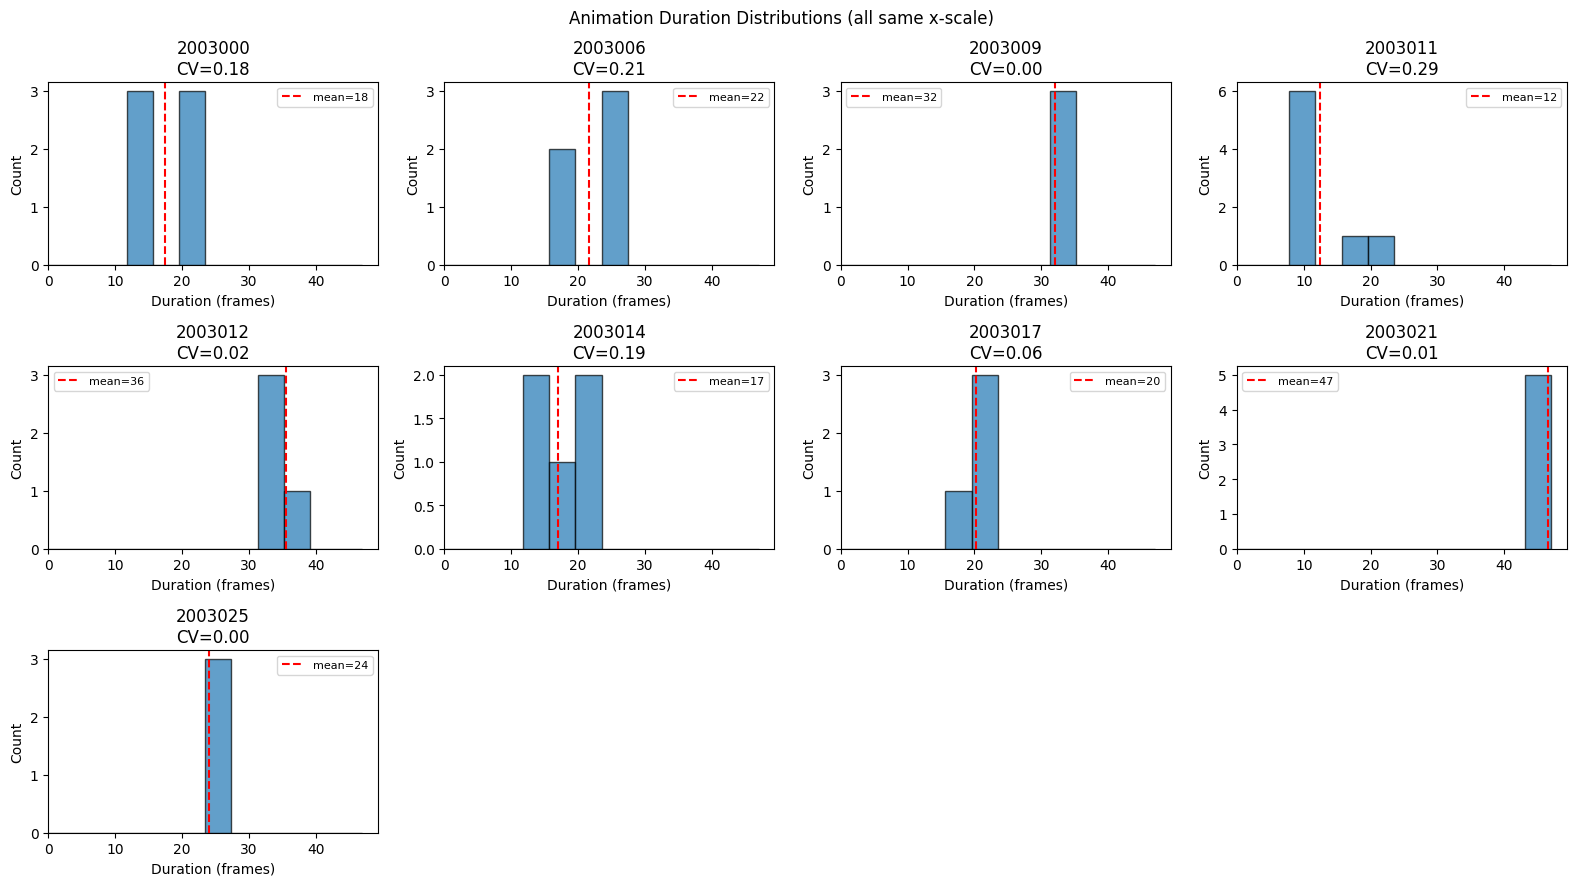

In [50]:
# Analyze animation durations (max elapsed frames per instance)

def get_animation_durations(recordings, target_anim_idx):
    """Get max elapsed frame for each instance of an animation."""
    durations = []
    for rec in recordings:
        anim_idx = rec["anim_idx"]
        elapsed = rec["elapsed_frames"]
        
        in_anim = False
        max_elapsed = 0
        
        for anim, el in zip(anim_idx, elapsed):
            if int(anim) == target_anim_idx:
                in_anim = True
                max_elapsed = max(max_elapsed, float(el))
            else:
                if in_anim and max_elapsed > 0:
                    durations.append(max_elapsed)
                in_anim = False
                max_elapsed = 0
        
        if in_anim and max_elapsed > 0:
            durations.append(max_elapsed)
    
    return durations

# Get durations for all animations with dodges
print("Animation Duration Analysis (max elapsed frames per instance)")
print("=" * 75)
print(f"{'Anim ID':<8} {'Name':<20} {'Count':>6} {'Mean':>8} {'Std':>8} {'CV':>8} {'Min':>8} {'Max':>8}")
print("-" * 75)

anim_duration_stats = {}
for anim_idx in sorted(dodge_by_anim.keys()):
    durations = get_animation_durations(recordings, anim_idx)
    if len(durations) >= 2:
        anim_name = IDX_TO_ANIM.get(anim_idx, "???")[:20]
        mean_dur = np.mean(durations)
        std_dur = np.std(durations)
        cv = std_dur / mean_dur if mean_dur > 0 else 0
        
        anim_duration_stats[anim_idx] = {
            'durations': durations,
            'mean': mean_dur,
            'std': std_dur,
            'cv': cv,
        }
        
        print(f"{anim_idx:<8} {anim_name:<20} {len(durations):>6} {mean_dur:>8.1f} {std_dur:>8.1f} {cv:>8.2f} {min(durations):>8.0f} {max(durations):>8.0f}")

print("\nInterpretation:")
print("- CV < 0.1: Very consistent duration (good for timing)")
print("- CV > 0.3: Variable duration (animation may be interruptible)")

# Plot duration distributions for animations with enough samples
anims_to_plot = {k: v for k, v in anim_duration_stats.items() if len(v['durations']) >= 3}

if anims_to_plot:
    n_anims = len(anims_to_plot)
    cols = min(4, n_anims)
    rows = (n_anims + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 3*rows))
    axes = np.atleast_1d(axes).flatten()
    
    # Find global max for consistent x-axis scale
    global_max = max(max(s['durations']) for s in anims_to_plot.values())
    
    for idx, (anim_idx, stats) in enumerate(sorted(anims_to_plot.items())):
        ax = axes[idx]
        durations = stats['durations']
        anim_name = IDX_TO_ANIM.get(anim_idx, f"idx_{anim_idx}")
        
        ax.hist(durations, bins=12, edgecolor='black', alpha=0.7, range=(0, global_max))
        ax.axvline(stats['mean'], color='red', linestyle='--', label=f"mean={stats['mean']:.0f}")
        ax.set_xlabel('Duration (frames)')
        ax.set_ylabel('Count')
        ax.set_title(f"{anim_name}\nCV={stats['cv']:.2f}")
        ax.set_xlim(0, global_max * 1.05)
        ax.legend(fontsize=8)
    
    for idx in range(n_anims, len(axes)):
        axes[idx].set_visible(False)
    
    plt.suptitle('Animation Duration Distributions (all same x-scale)', fontsize=12)
    plt.tight_layout()
    plt.show()

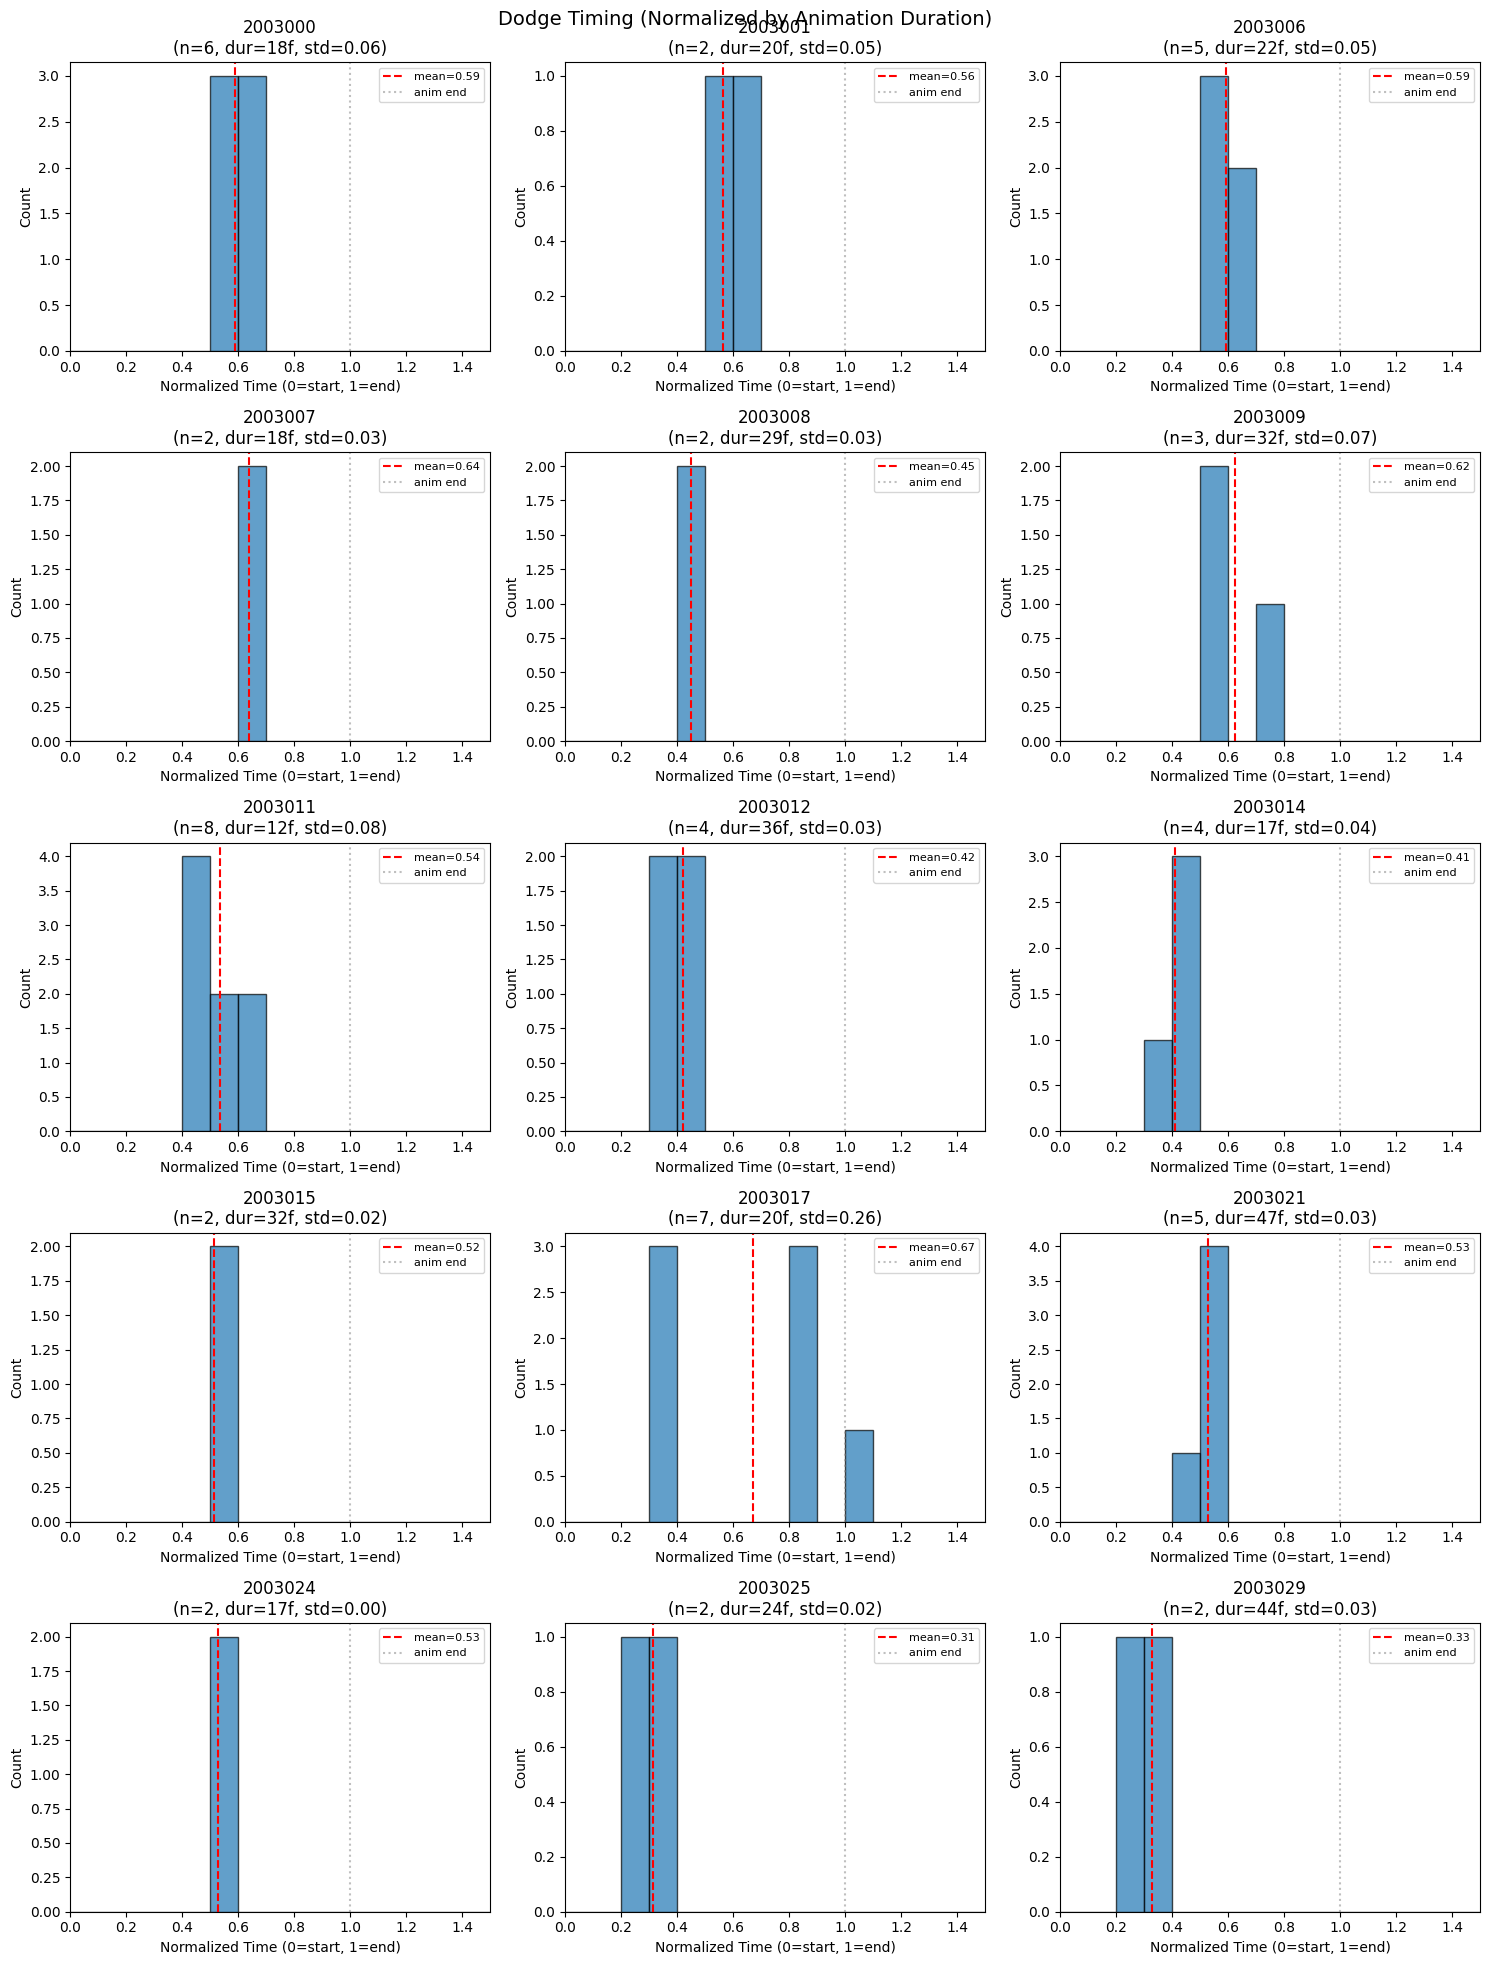


Normalized Dodge Timing Summary:
Anim                  Avg Dur  Dodges     Mean      Std
-------------------------------------------------------
2003000                    18       6     0.59     0.06
2003001                    20       2     0.56     0.05
2003006                    22       5     0.59     0.05
2003007                    18       2     0.64     0.03
2003008                    29       2     0.45     0.03
2003009                    32       3     0.62     0.07
2003011                    12       8     0.54     0.08
2003012                    36       4     0.42     0.03
2003014                    17       4     0.41     0.04
2003015                    32       2     0.52     0.02
2003017                    20       7     0.67     0.26
2003021                    47       5     0.53     0.03
2003024                    17       2     0.53     0.00
2003025                    24       2     0.31     0.02
2003029                    44       2     0.33     0.03


In [48]:
# Histogram of dodge elapsed times per animation - NORMALIZED by animation duration

def get_animation_durations(recordings, target_anim_idx):
    """Get max elapsed frame for each instance of an animation."""
    durations = []
    for rec in recordings:
        anim_idx = rec["anim_idx"]
        elapsed = rec["elapsed_frames"]
        
        in_anim = False
        max_elapsed = 0
        
        for anim, el in zip(anim_idx, elapsed):
            if int(anim) == target_anim_idx:
                in_anim = True
                max_elapsed = max(max_elapsed, float(el))
            else:
                if in_anim and max_elapsed > 0:
                    durations.append(max_elapsed)
                in_anim = False
                max_elapsed = 0
        
        if in_anim and max_elapsed > 0:
            durations.append(max_elapsed)
    
    return durations

# Calculate normalized dodge timing
normalized_dodge_timing = {}
anim_avg_durations = {}

for anim_idx, onsets in dodge_by_anim.items():
    durations = get_animation_durations(recordings, anim_idx)
    if durations:
        avg_duration = np.mean(durations)
        anim_avg_durations[anim_idx] = avg_duration
        
        # Normalize dodge times by average duration
        normalized_times = [o['boss_elapsed'] / avg_duration for o in onsets]
        normalized_dodge_timing[anim_idx] = normalized_times

# Plot normalized histograms
anims_with_dodges = {k: v for k, v in normalized_dodge_timing.items() if len(v) >= 2}

if anims_with_dodges:
    n_anims = len(anims_with_dodges)
    cols = min(3, n_anims)
    rows = (n_anims + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4*rows))
    axes = np.atleast_1d(axes).flatten()
    
    for idx, (anim_idx, norm_times) in enumerate(sorted(anims_with_dodges.items())):
        ax = axes[idx]
        anim_name = IDX_TO_ANIM.get(anim_idx, f"idx_{anim_idx}")
        avg_dur = anim_avg_durations[anim_idx]
        
        ax.hist(norm_times, bins=15, edgecolor='black', alpha=0.7, range=(0, 1.5))
        ax.axvline(np.mean(norm_times), color='red', linestyle='--', 
                   label=f'mean={np.mean(norm_times):.2f}')
        ax.axvline(1.0, color='gray', linestyle=':', alpha=0.5, label='anim end')
        ax.set_xlabel('Normalized Time (0=start, 1=end)')
        ax.set_ylabel('Count')
        ax.set_title(f'{anim_name}\n(n={len(norm_times)}, dur={avg_dur:.0f}f, std={np.std(norm_times):.2f})')
        ax.legend(fontsize=8)
        ax.set_xlim(0, 1.5)
    
    for idx in range(n_anims, len(axes)):
        axes[idx].set_visible(False)
    
    plt.suptitle('Dodge Timing (Normalized by Animation Duration)', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print("\nNormalized Dodge Timing Summary:")
    print(f"{'Anim':<20} {'Avg Dur':>8} {'Dodges':>7} {'Mean':>8} {'Std':>8}")
    print("-" * 55)
    for anim_idx in sorted(anims_with_dodges.keys()):
        norm_times = normalized_dodge_timing[anim_idx]
        anim_name = IDX_TO_ANIM.get(anim_idx, f"idx_{anim_idx}")[:20]
        avg_dur = anim_avg_durations[anim_idx]
        print(f"{anim_name:<20} {avg_dur:>8.0f} {len(norm_times):>7} {np.mean(norm_times):>8.2f} {np.std(norm_times):>8.2f}")
else:
    print("Not enough dodge data for normalized histograms")

Found 8 instances of animation 2003011


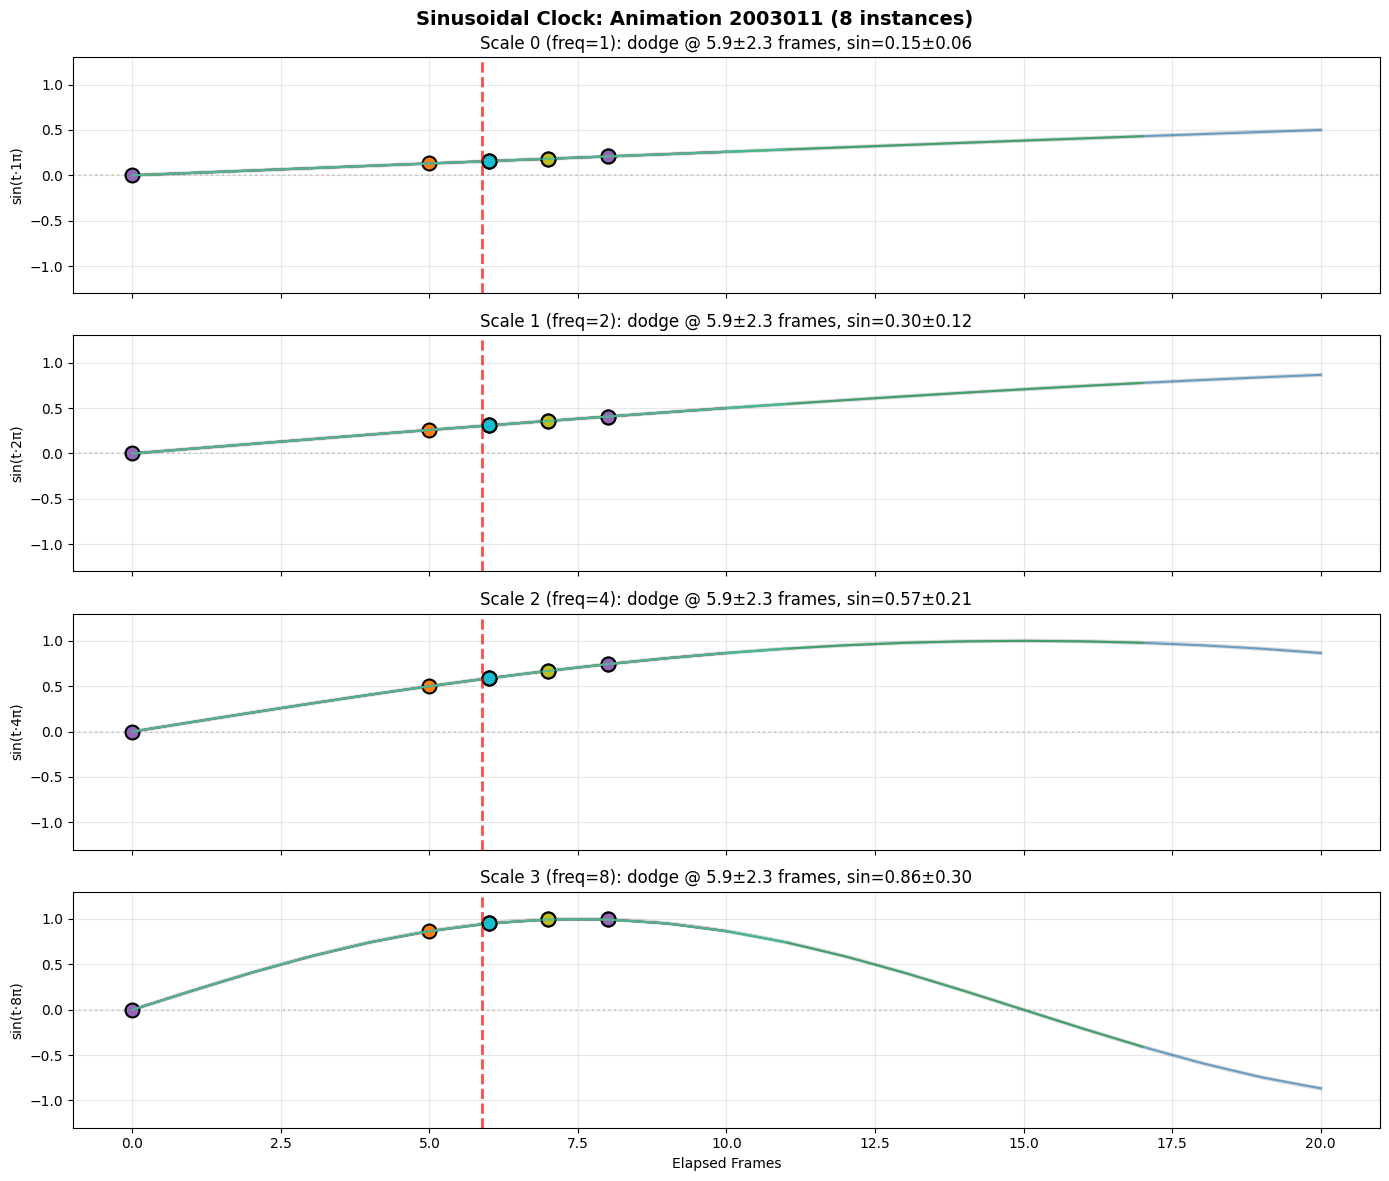


Dodge timing summary:
  Count: 9
  Mean: 5.9 frames
  Std: 2.3 frames
  CV: 0.39
  Range: [0, 8]


In [44]:
# Plot for a specific animation
# Change this to an animation index that has dodges!
TARGET_ANIM = 19  # <-- UPDATE THIS based on dodge_by_anim output above

plot_sinusoidal_timeline(recordings, TARGET_ANIM)

## Build Dodge Window Model

Creates a model that defines optimal dodge timing windows for each boss animation based on human demonstrations.

In [ ]:
from dodge_window_model import DodgeWindowModel

# Build model from recordings
model = DodgeWindowModel.from_recordings(
    recordings=recordings,
    anim_vocab=IDX_TO_ANIM,
    dodge_anim_ranges=DODGE_ANIM_RANGES,
    min_dodges=2,
    min_instances=2,
)

model.print_summary()

# Save model
model.save("dodge_windows.json")
print(f"\nModel saved! {len(model.windows)} animations with dodge windows.")

In [ ]:
# Visualize dodge windows and reward function

if model.windows:
    n_windows = len(model.windows)
    cols = min(3, n_windows)
    rows = (n_windows + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4*rows))
    axes = np.atleast_1d(axes).flatten()
    
    for idx, (anim_idx, window) in enumerate(sorted(model.windows.items())):
        ax = axes[idx]
        
        # X-axis: elapsed frames from 0 to duration
        max_x = window.duration_mean * 1.3
        x = np.linspace(0, max_x, 200)
        
        # Reward curve (Gaussian)
        rewards = [window.get_reward(t) for t in x]
        
        # Plot reward curve
        ax.fill_between(x, rewards, alpha=0.3, color='green', label='Reward')
        ax.plot(x, rewards, 'g-', linewidth=2)
        
        # Mark dodge window (2 sigma)
        window_start = window.dodge_mean_frames - 2 * window.dodge_std_frames
        window_end = window.dodge_mean_frames + 2 * window.dodge_std_frames
        ax.axvspan(window_start, window_end, alpha=0.2, color='blue', label='2σ window')
        
        # Mark mean and duration
        ax.axvline(window.dodge_mean_frames, color='red', linestyle='--', label=f'Mean={window.dodge_mean_frames:.0f}')
        ax.axvline(window.duration_mean, color='gray', linestyle=':', label=f'Dur={window.duration_mean:.0f}')
        
        ax.set_xlabel('Elapsed Frames')
        ax.set_ylabel('Reward')
        ax.set_title(f'{window.anim_name}\n(n={window.n_dodges} dodges)')
        ax.set_xlim(0, max_x)
        ax.set_ylim(0, 1.1)
        ax.legend(fontsize=7, loc='upper right')
        ax.grid(True, alpha=0.3)
    
    for idx in range(n_windows, len(axes)):
        axes[idx].set_visible(False)
    
    plt.suptitle('Dodge Windows: Reward = Gaussian(elapsed_frames | mean, std)', fontsize=12)
    plt.tight_layout()
    plt.show()
else:
    print("No dodge windows in model")


Found 8 instances of animation 2003011


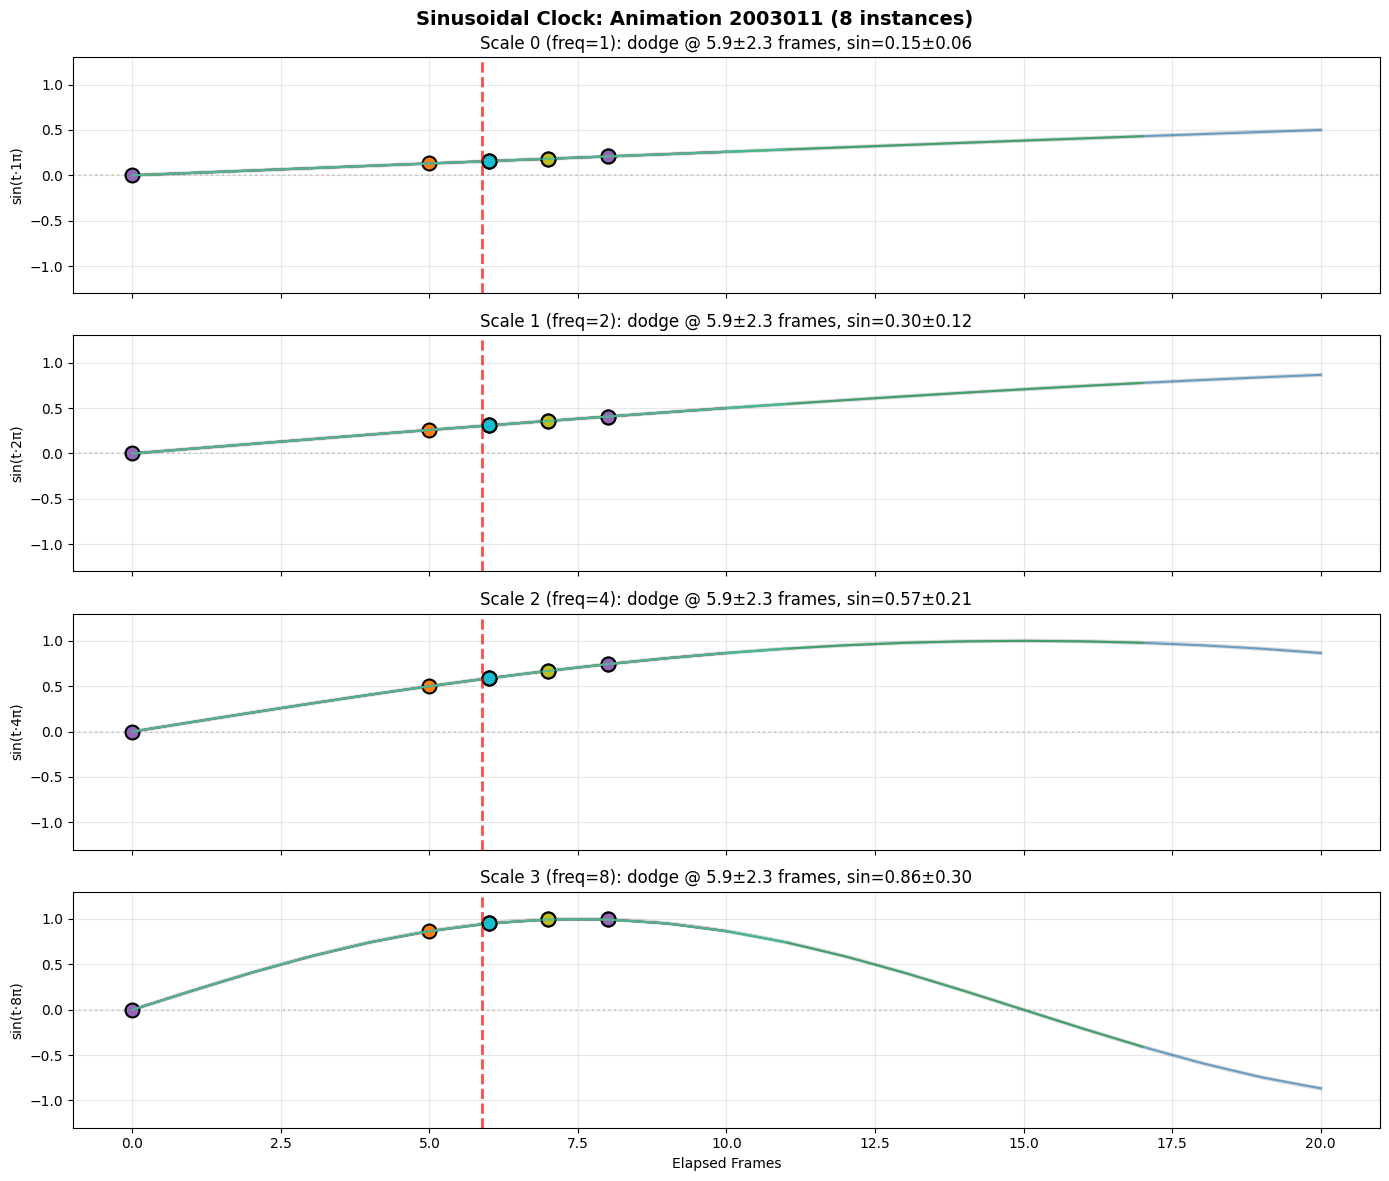


Dodge timing summary:
  Count: 9
  Mean: 5.9 frames
  Std: 2.3 frames
  CV: 0.39
  Range: [0, 8]

Found 4 instances of animation 2003017


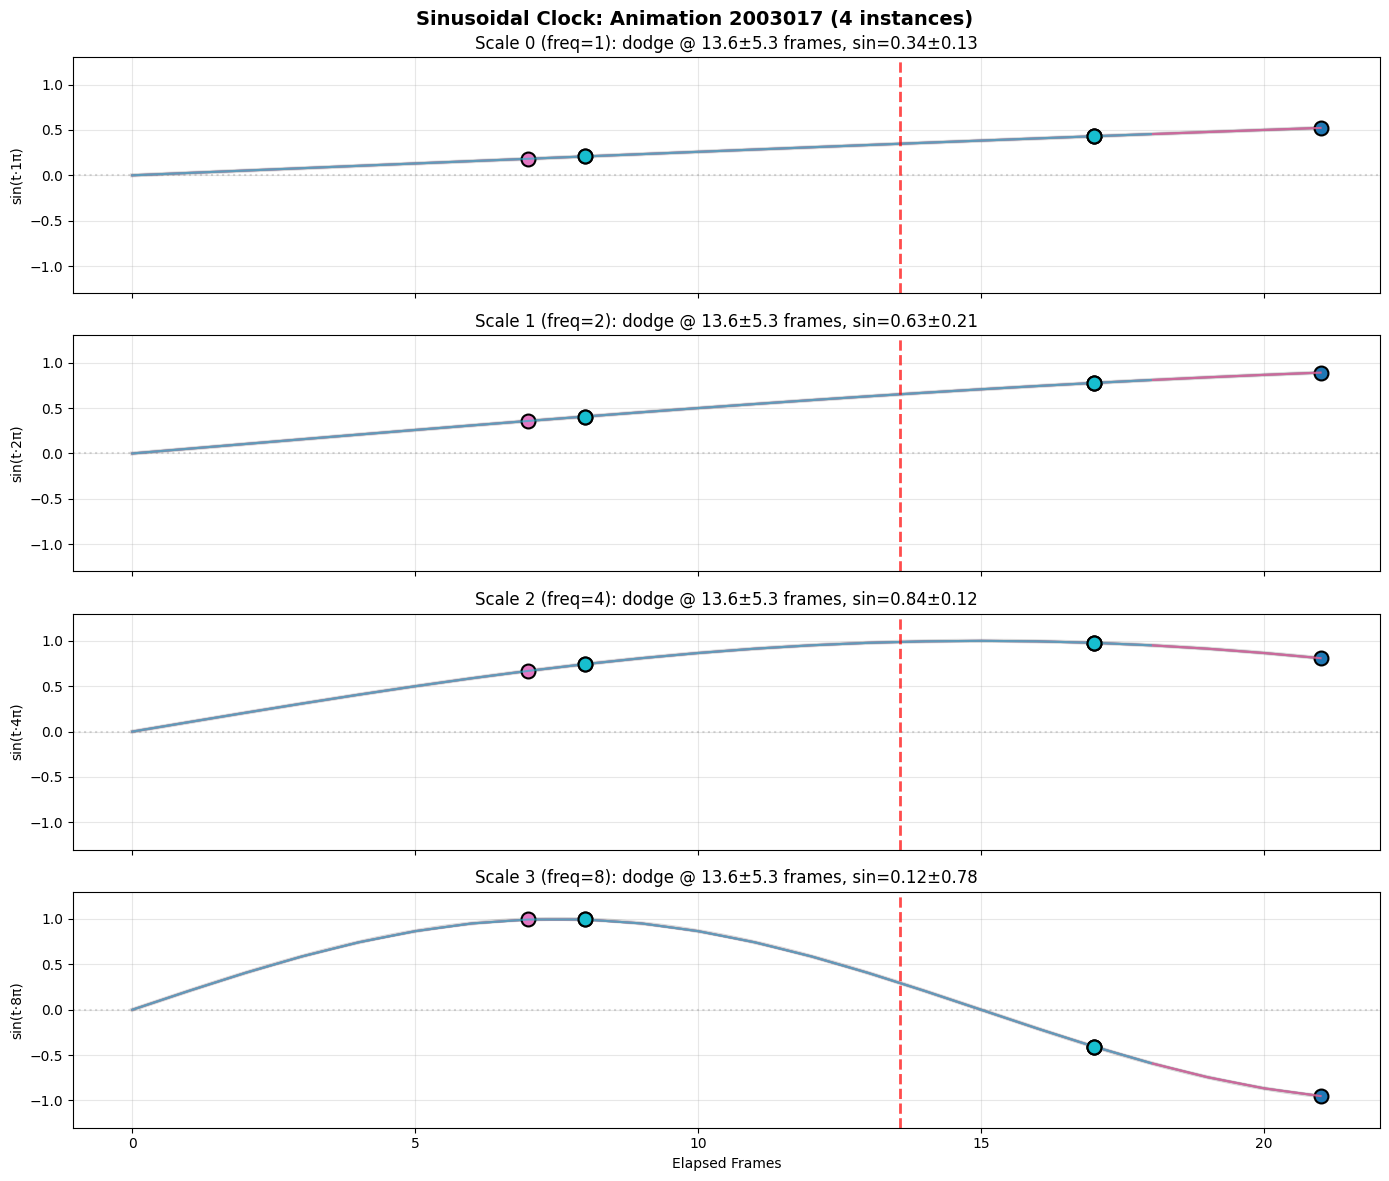


Dodge timing summary:
  Count: 7
  Mean: 13.6 frames
  Std: 5.3 frames
  CV: 0.39
  Range: [7, 21]

Found 6 instances of animation 2003000


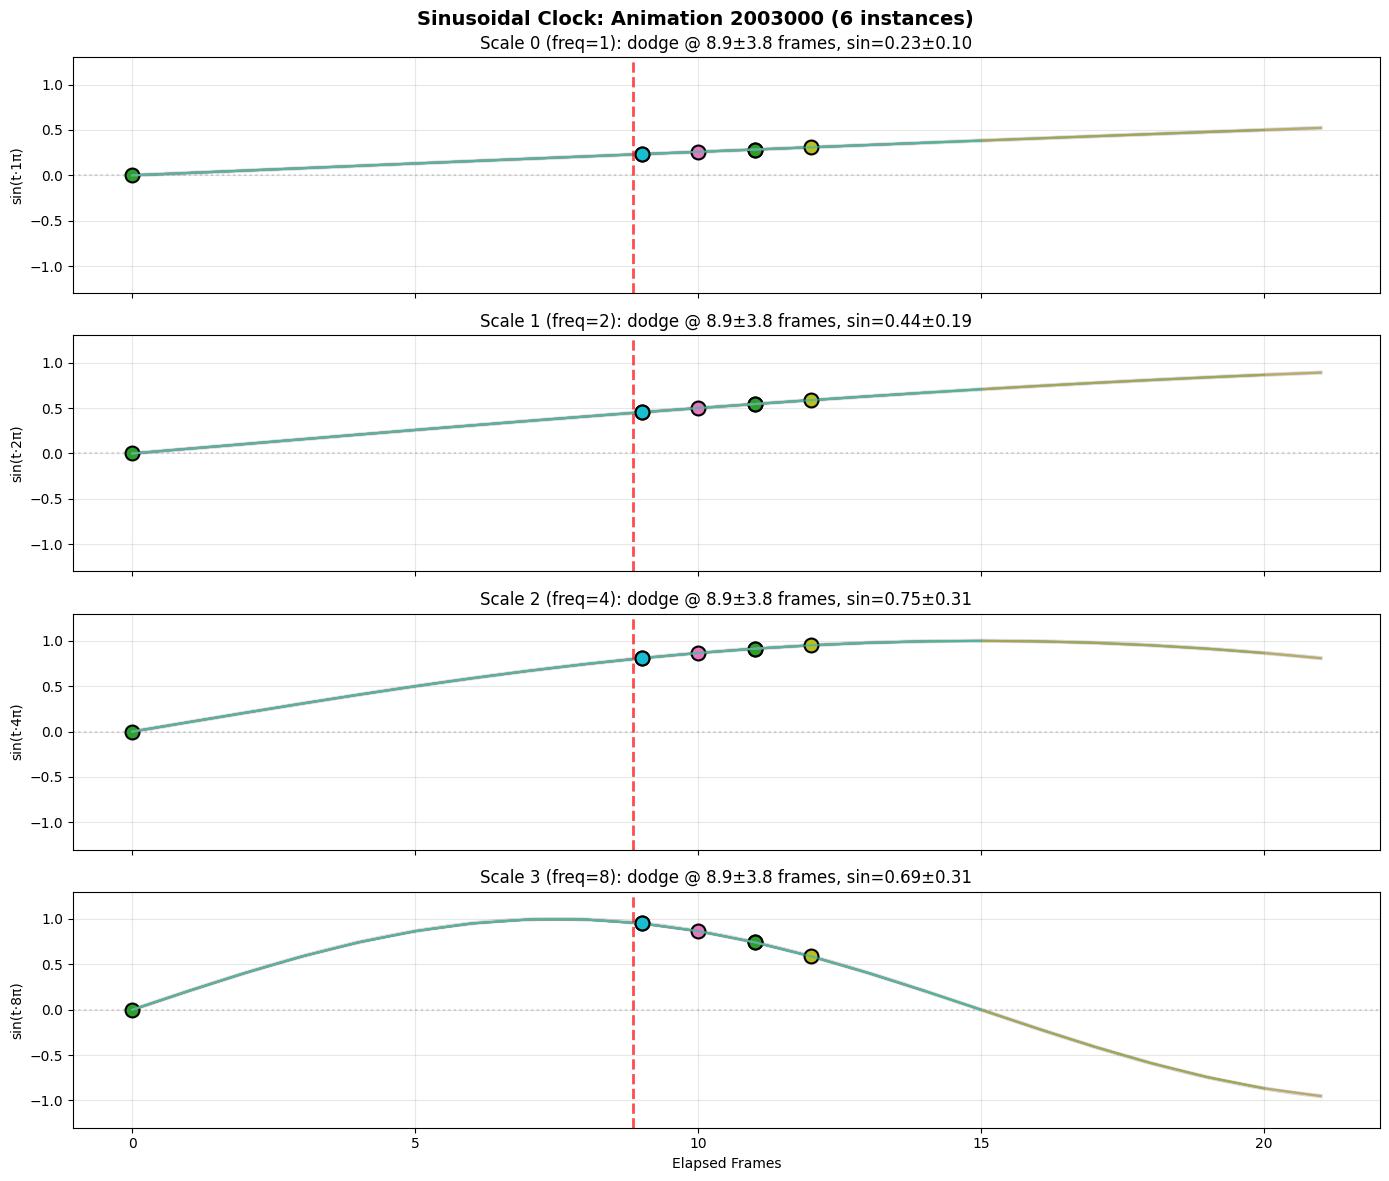


Dodge timing summary:
  Count: 7
  Mean: 8.9 frames
  Std: 3.8 frames
  CV: 0.42
  Range: [0, 12]

Found 5 instances of animation 2003021


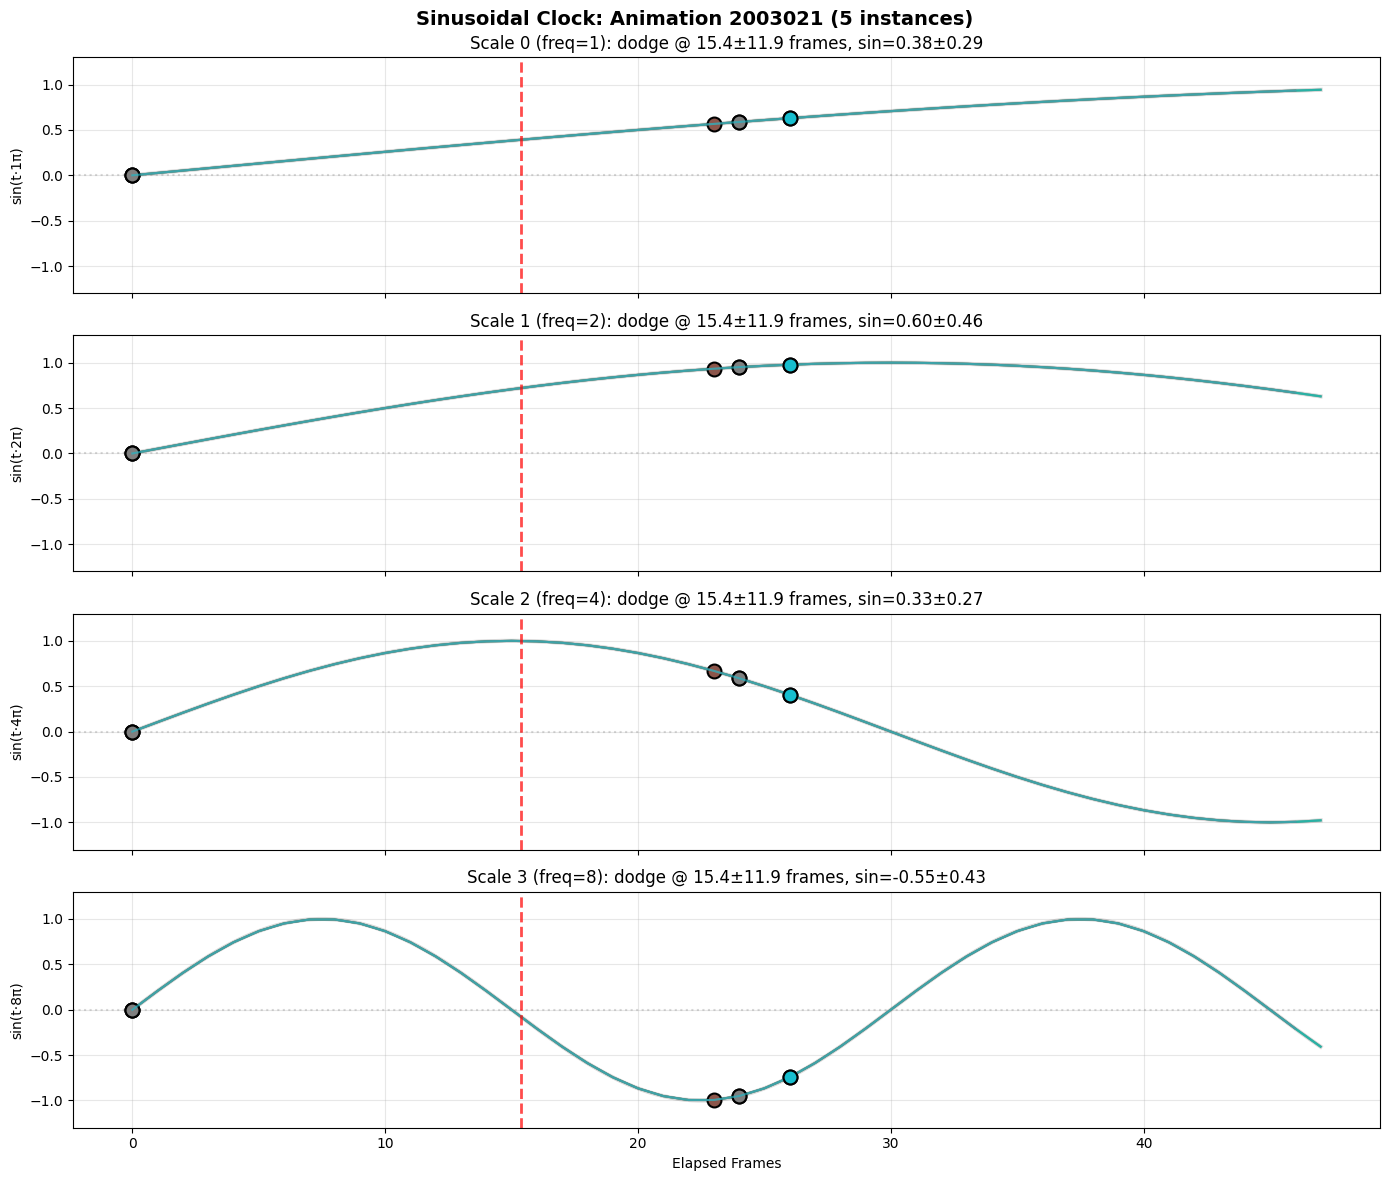


Dodge timing summary:
  Count: 8
  Mean: 15.4 frames
  Std: 11.9 frames
  CV: 0.78
  Range: [0, 26]

Found 5 instances of animation 2003006


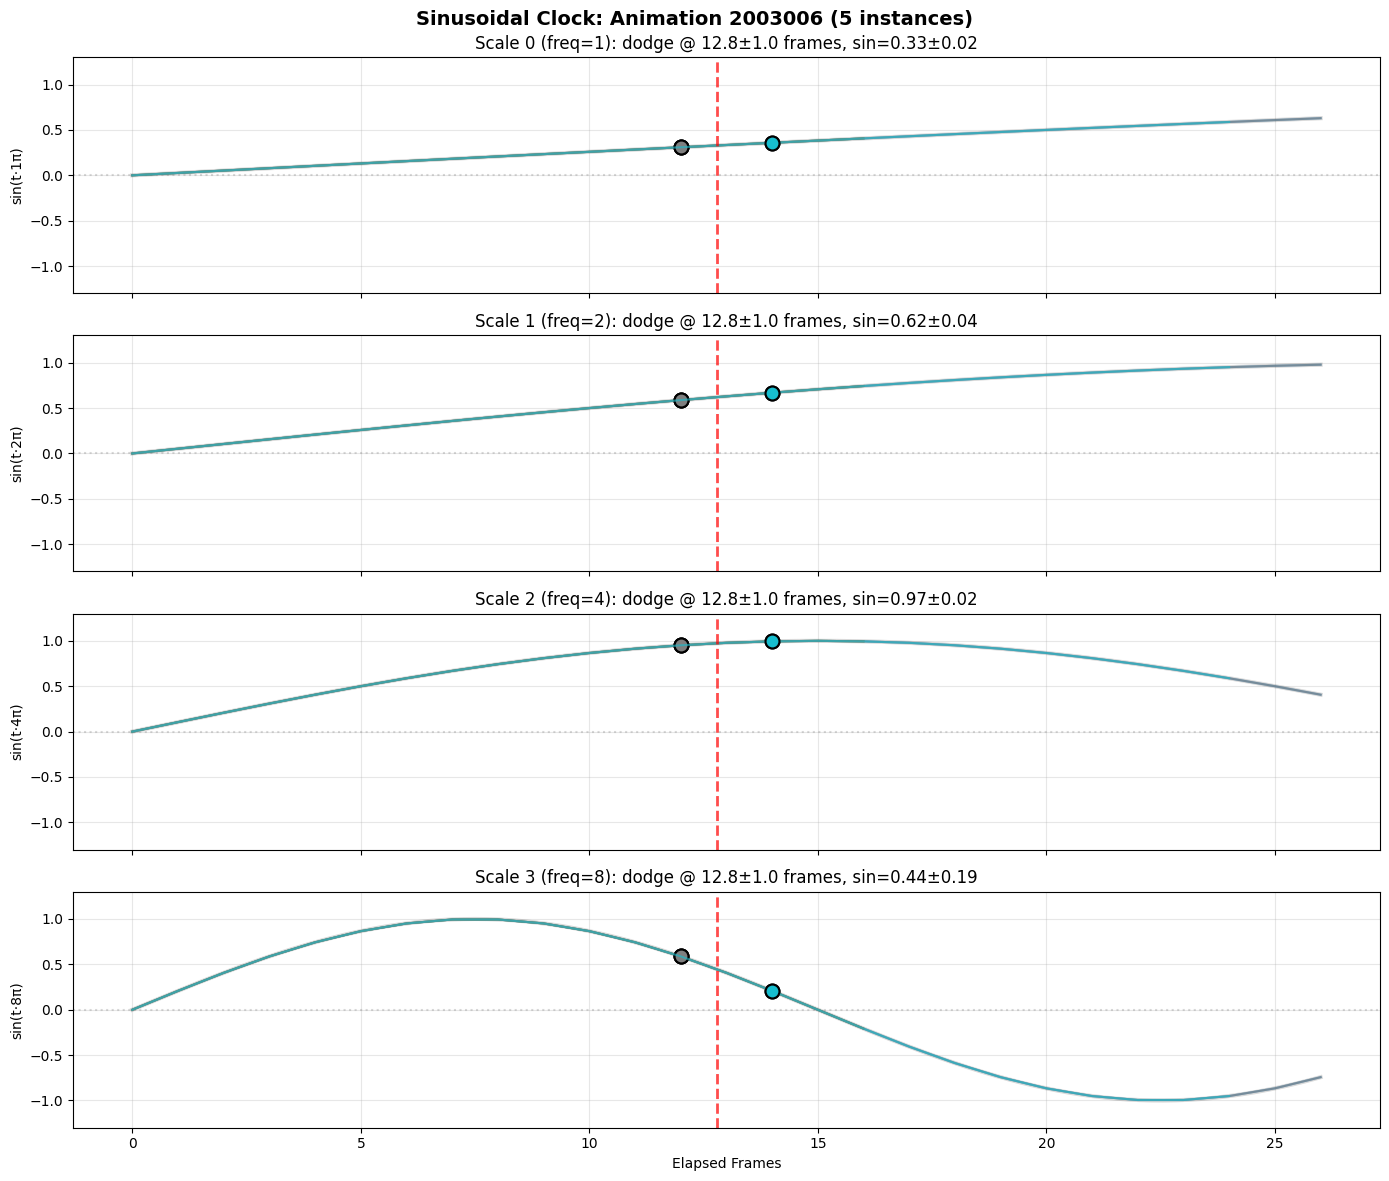


Dodge timing summary:
  Count: 5
  Mean: 12.8 frames
  Std: 1.0 frames
  CV: 0.08
  Range: [12, 14]

Found 5 instances of animation 2003014


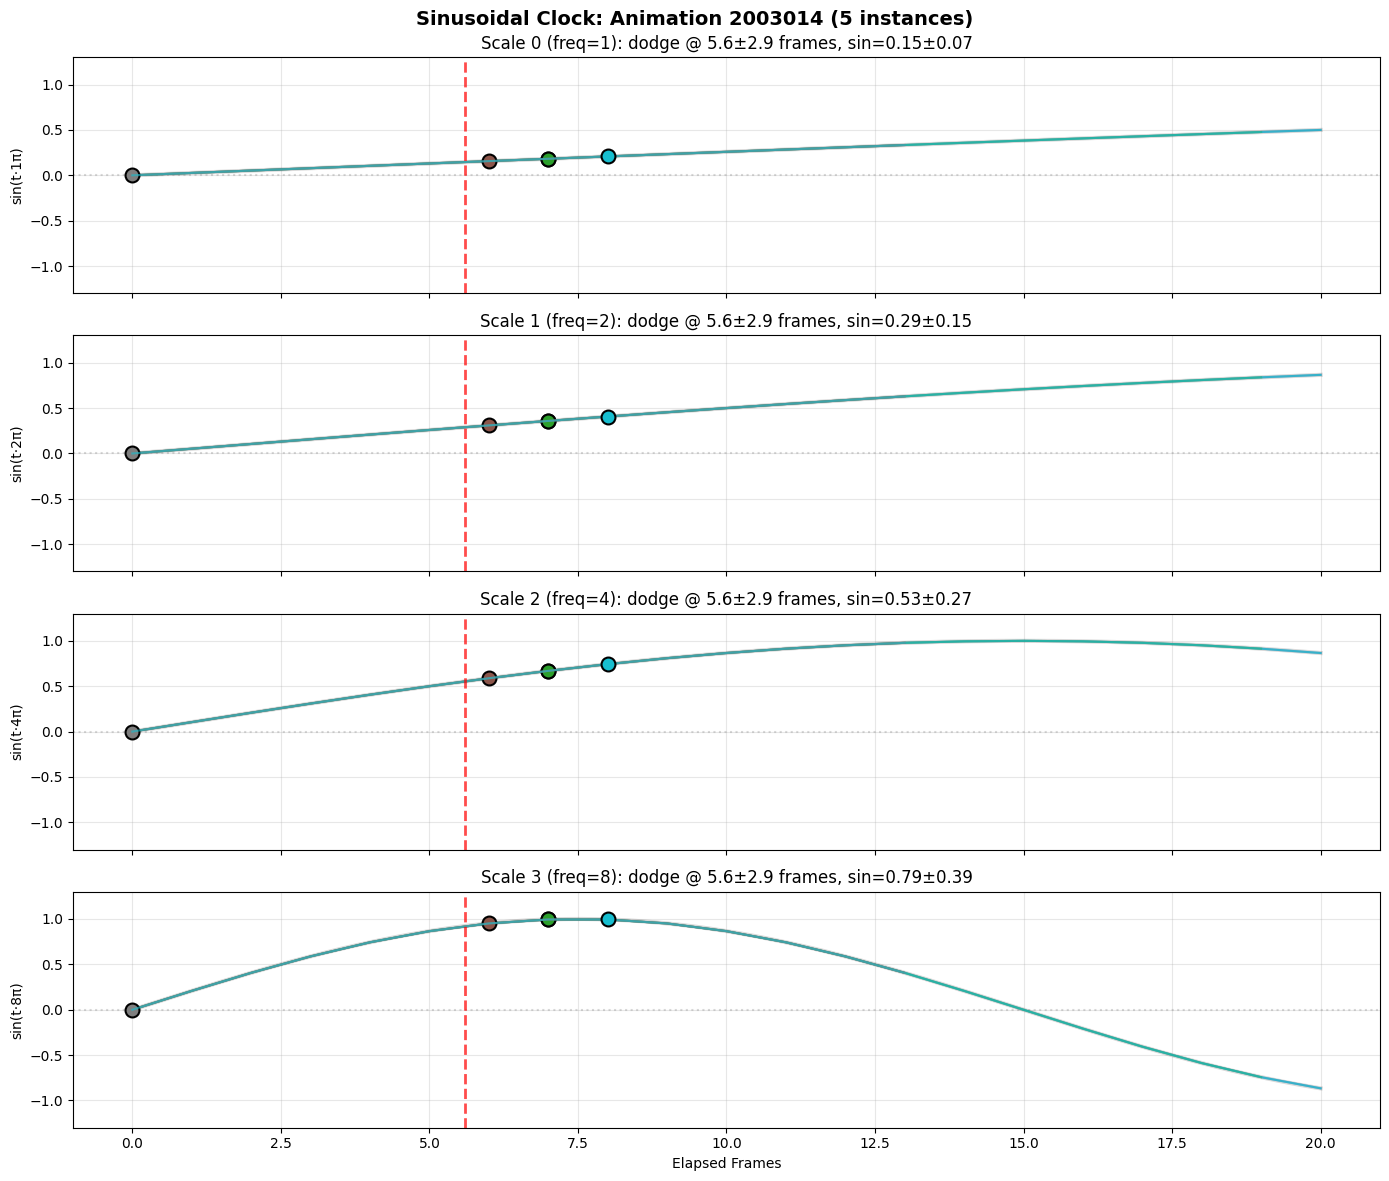


Dodge timing summary:
  Count: 5
  Mean: 5.6 frames
  Std: 2.9 frames
  CV: 0.51
  Range: [0, 8]

Found 4 instances of animation 2003012


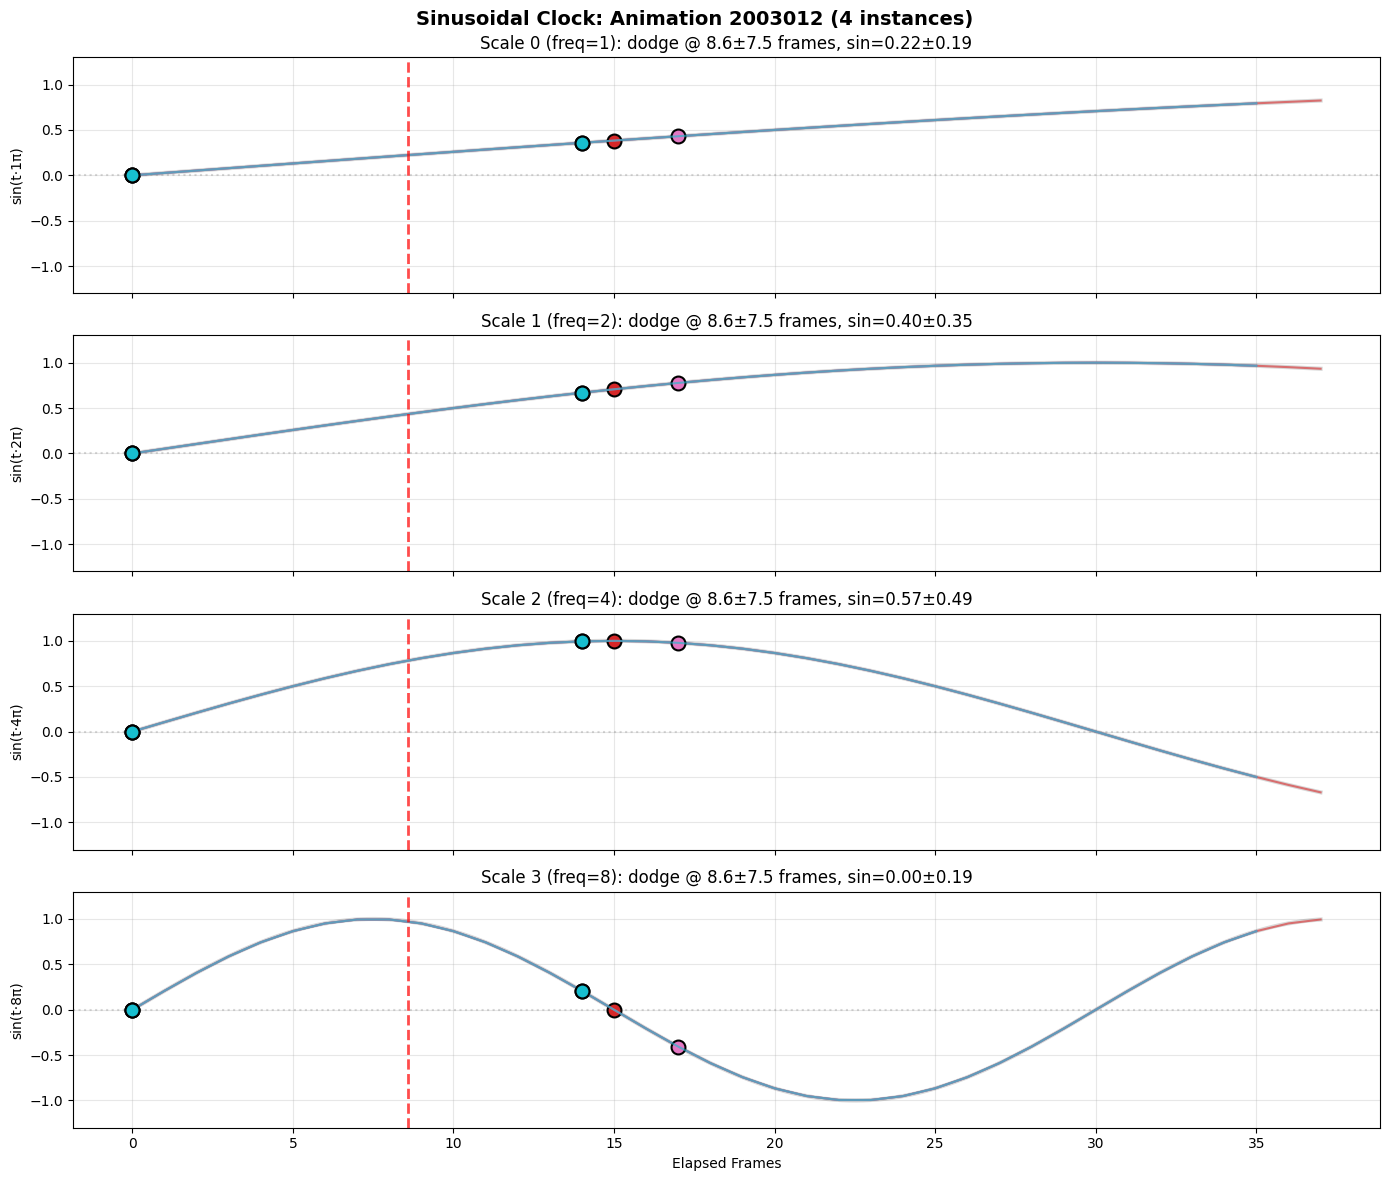


Dodge timing summary:
  Count: 7
  Mean: 8.6 frames
  Std: 7.5 frames
  CV: 0.87
  Range: [0, 17]

Found 3 instances of animation 2003009


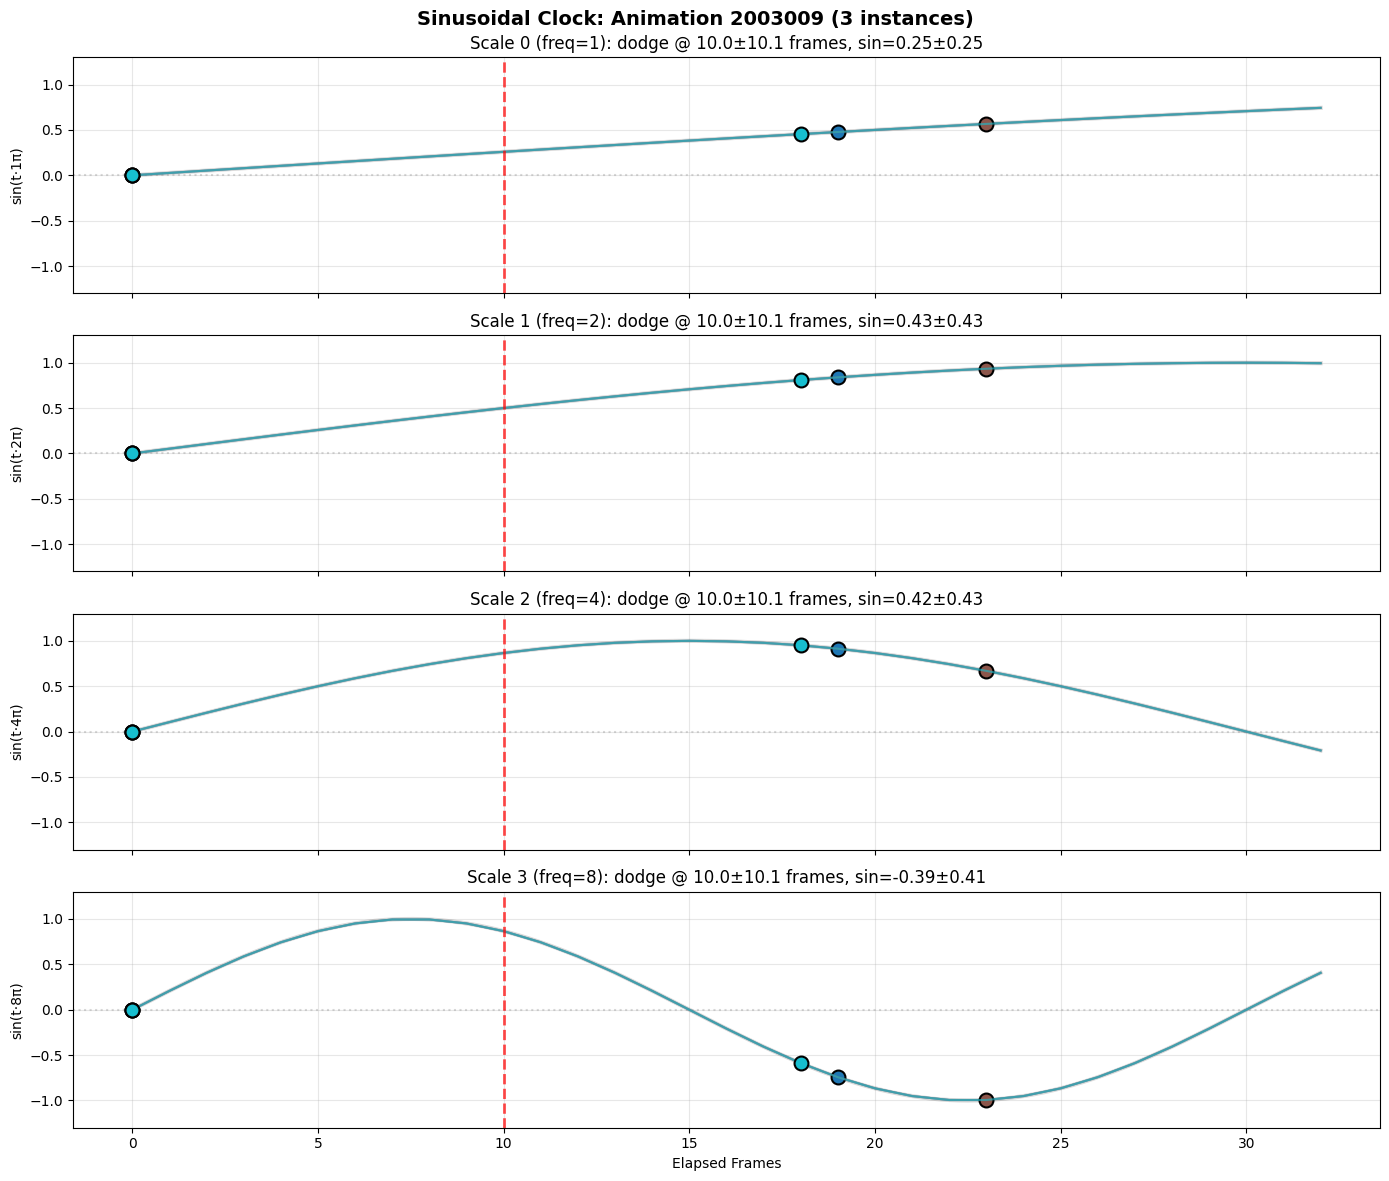


Dodge timing summary:
  Count: 6
  Mean: 10.0 frames
  Std: 10.1 frames
  CV: 1.01
  Range: [0, 23]

Found 2 instances of animation 2003029


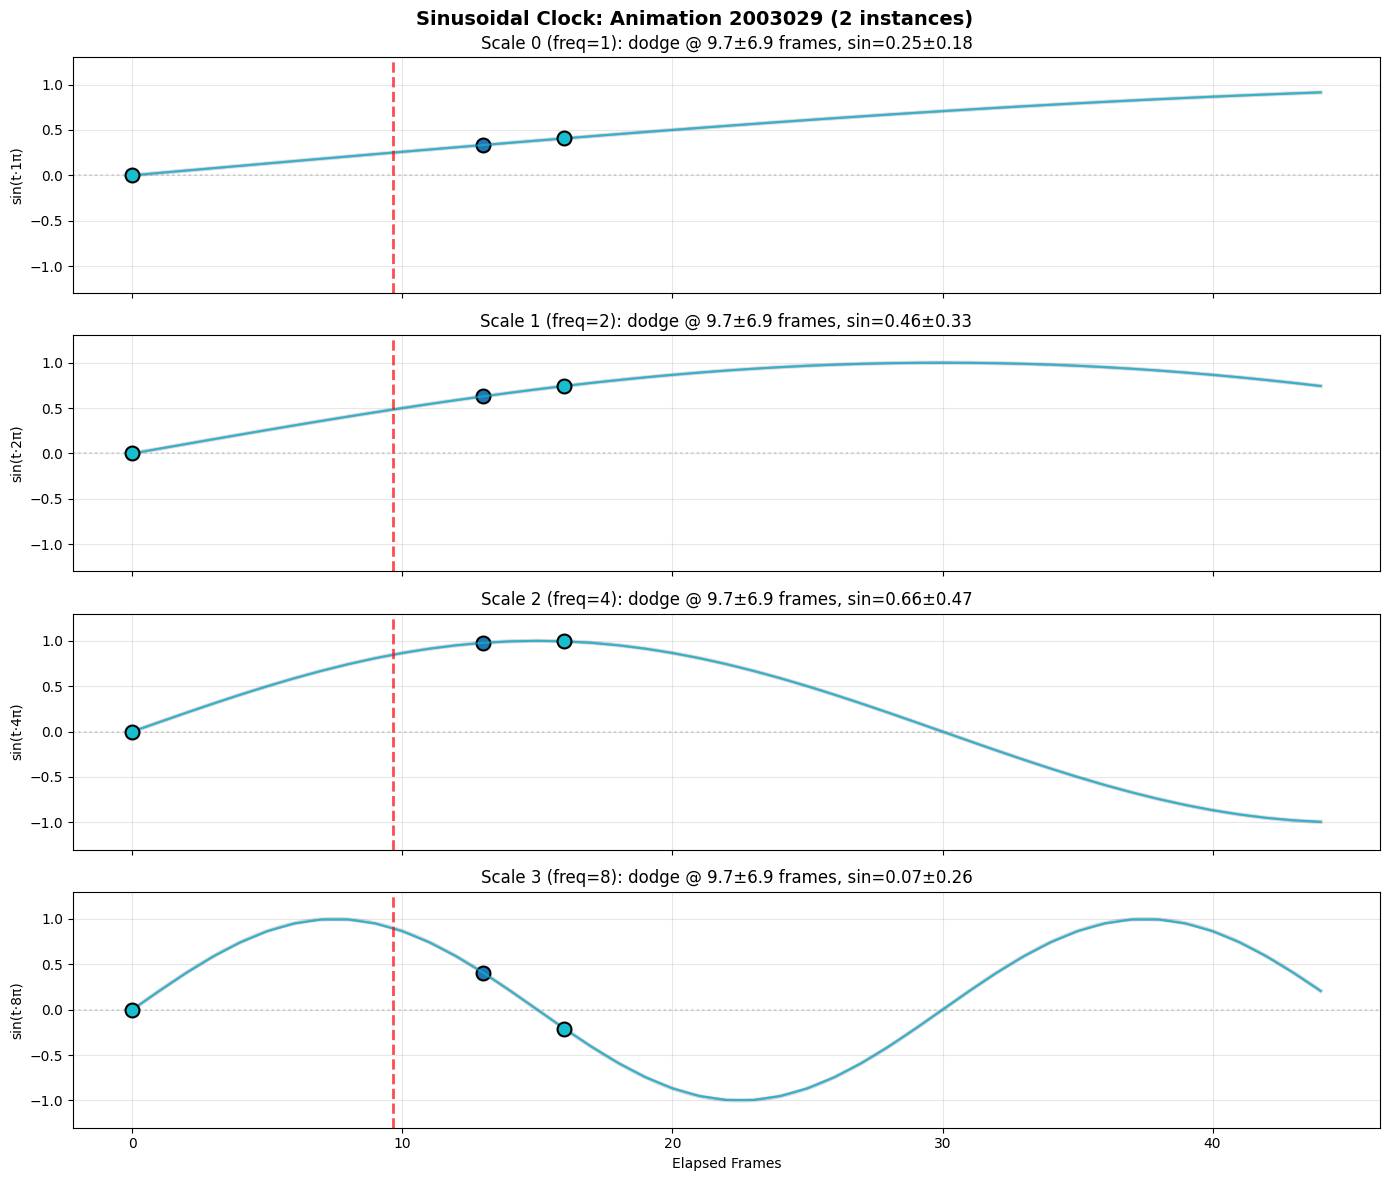


Dodge timing summary:
  Count: 3
  Mean: 9.7 frames
  Std: 6.9 frames
  CV: 0.72
  Range: [0, 16]

Found 2 instances of animation 2003001


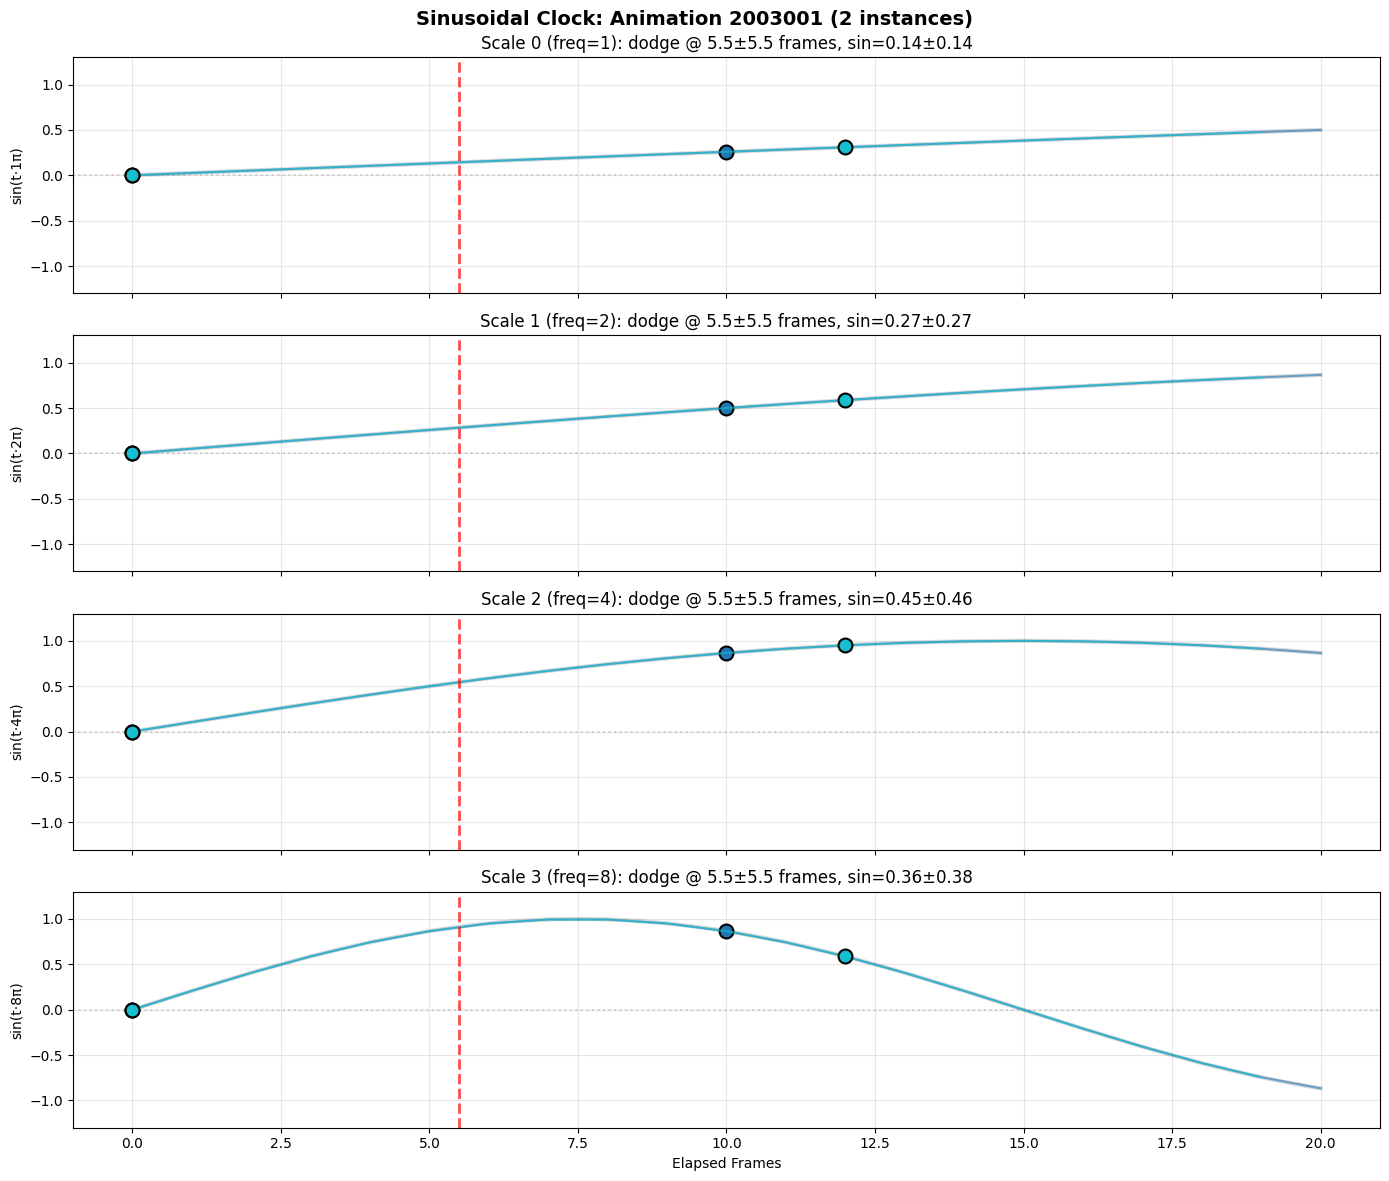


Dodge timing summary:
  Count: 4
  Mean: 5.5 frames
  Std: 5.5 frames
  CV: 1.01
  Range: [0, 12]

Found 2 instances of animation 2003007


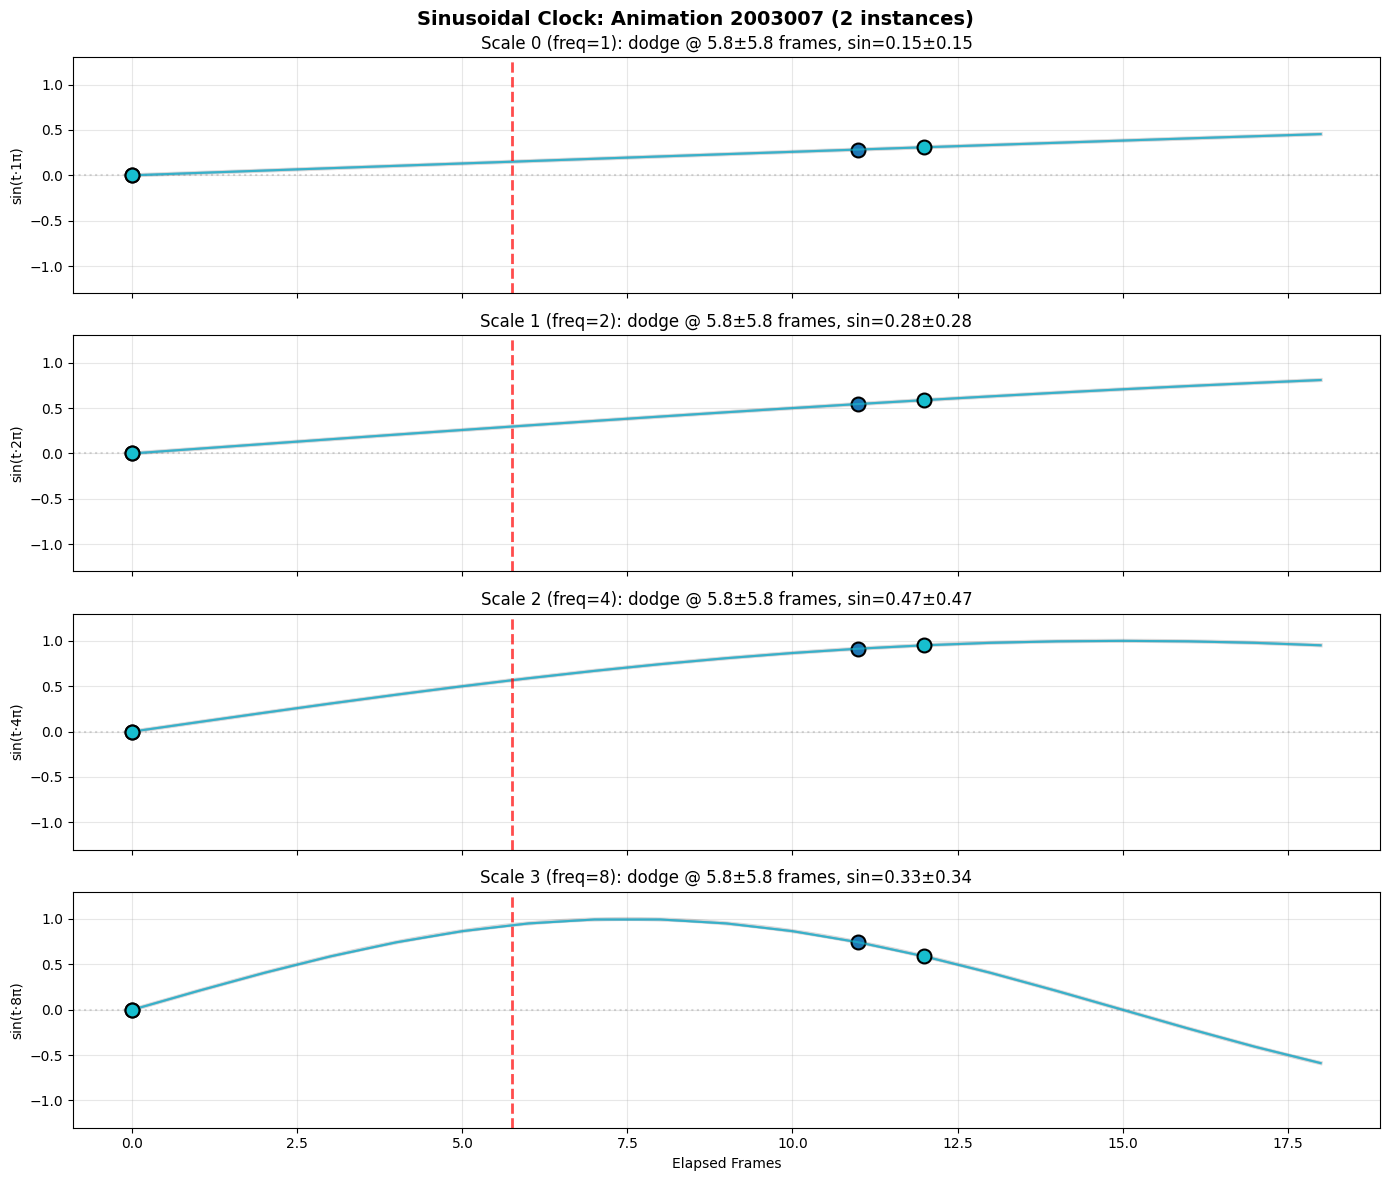


Dodge timing summary:
  Count: 4
  Mean: 5.8 frames
  Std: 5.8 frames
  CV: 1.00
  Range: [0, 12]

Found 2 instances of animation 2003008


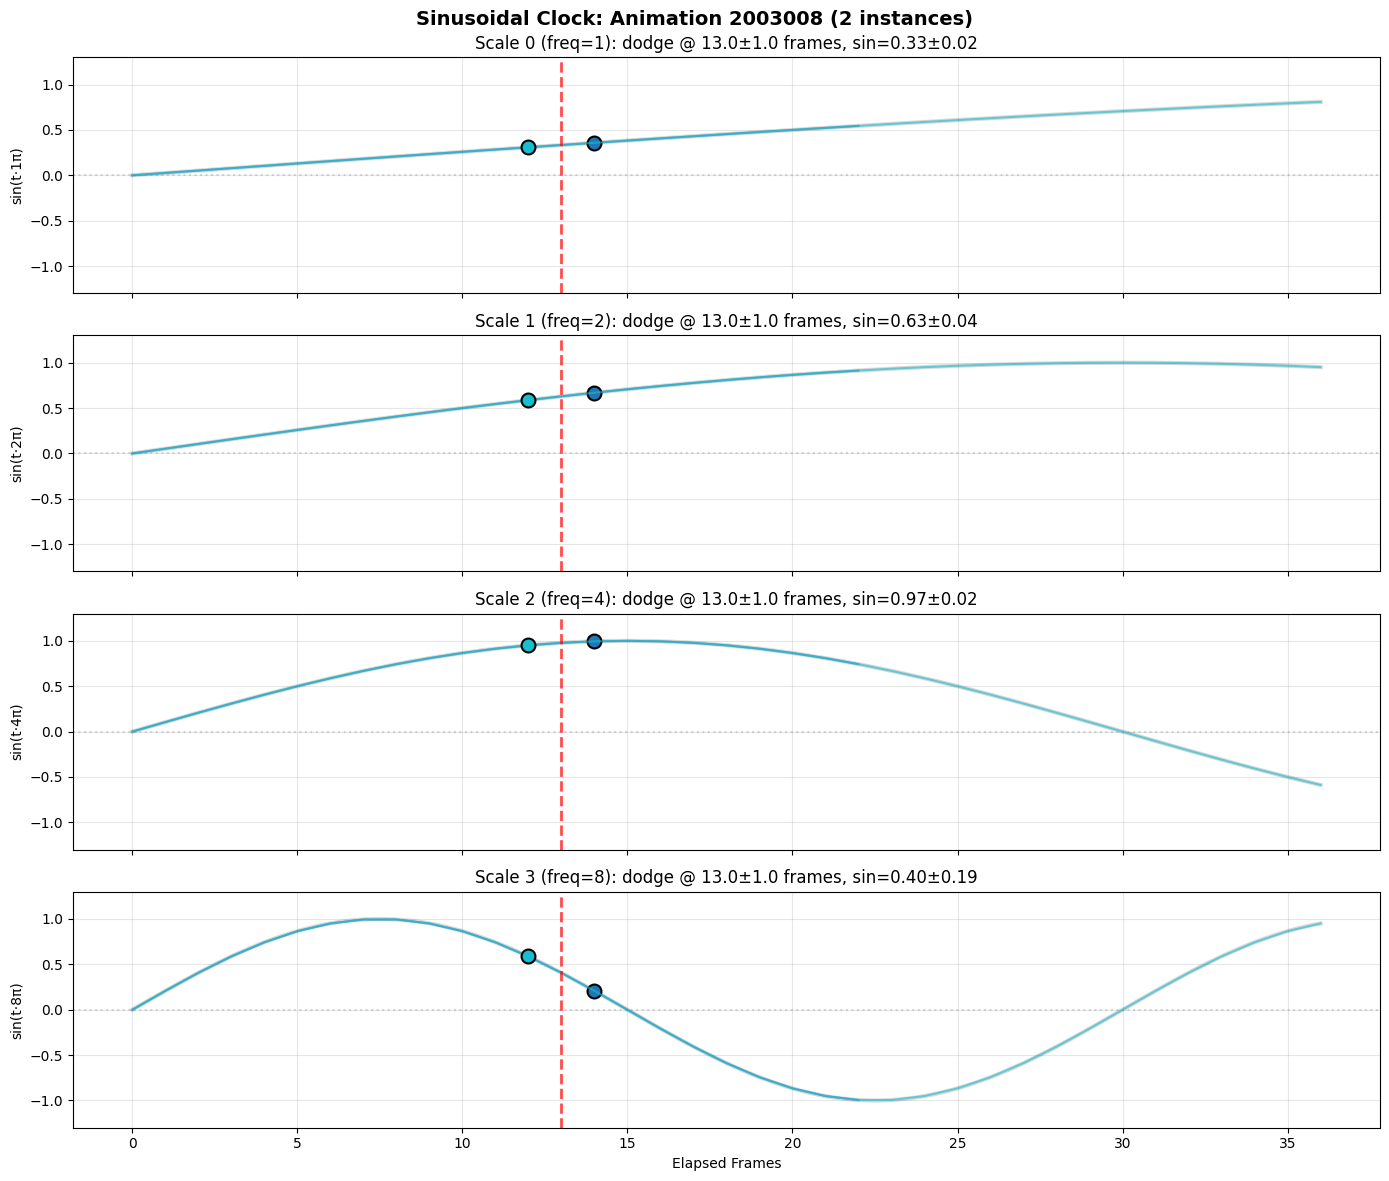


Dodge timing summary:
  Count: 2
  Mean: 13.0 frames
  Std: 1.0 frames
  CV: 0.08
  Range: [12, 14]

Found 2 instances of animation 2003015


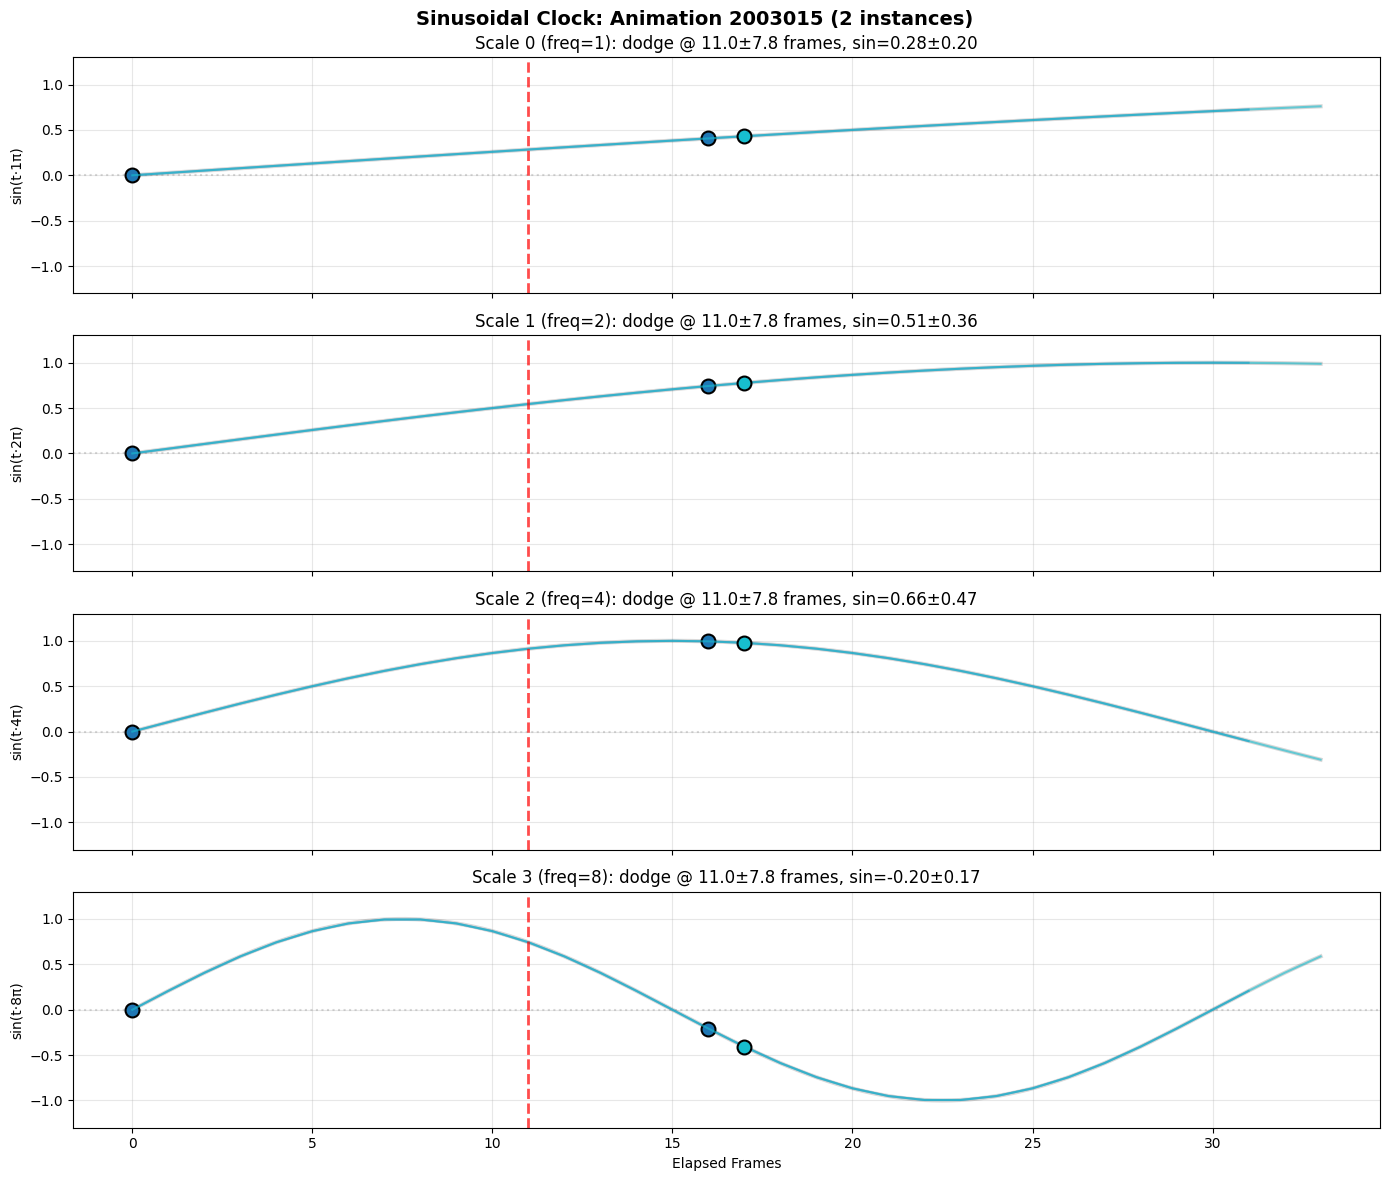


Dodge timing summary:
  Count: 3
  Mean: 11.0 frames
  Std: 7.8 frames
  CV: 0.71
  Range: [0, 17]

Found 3 instances of animation 2003025


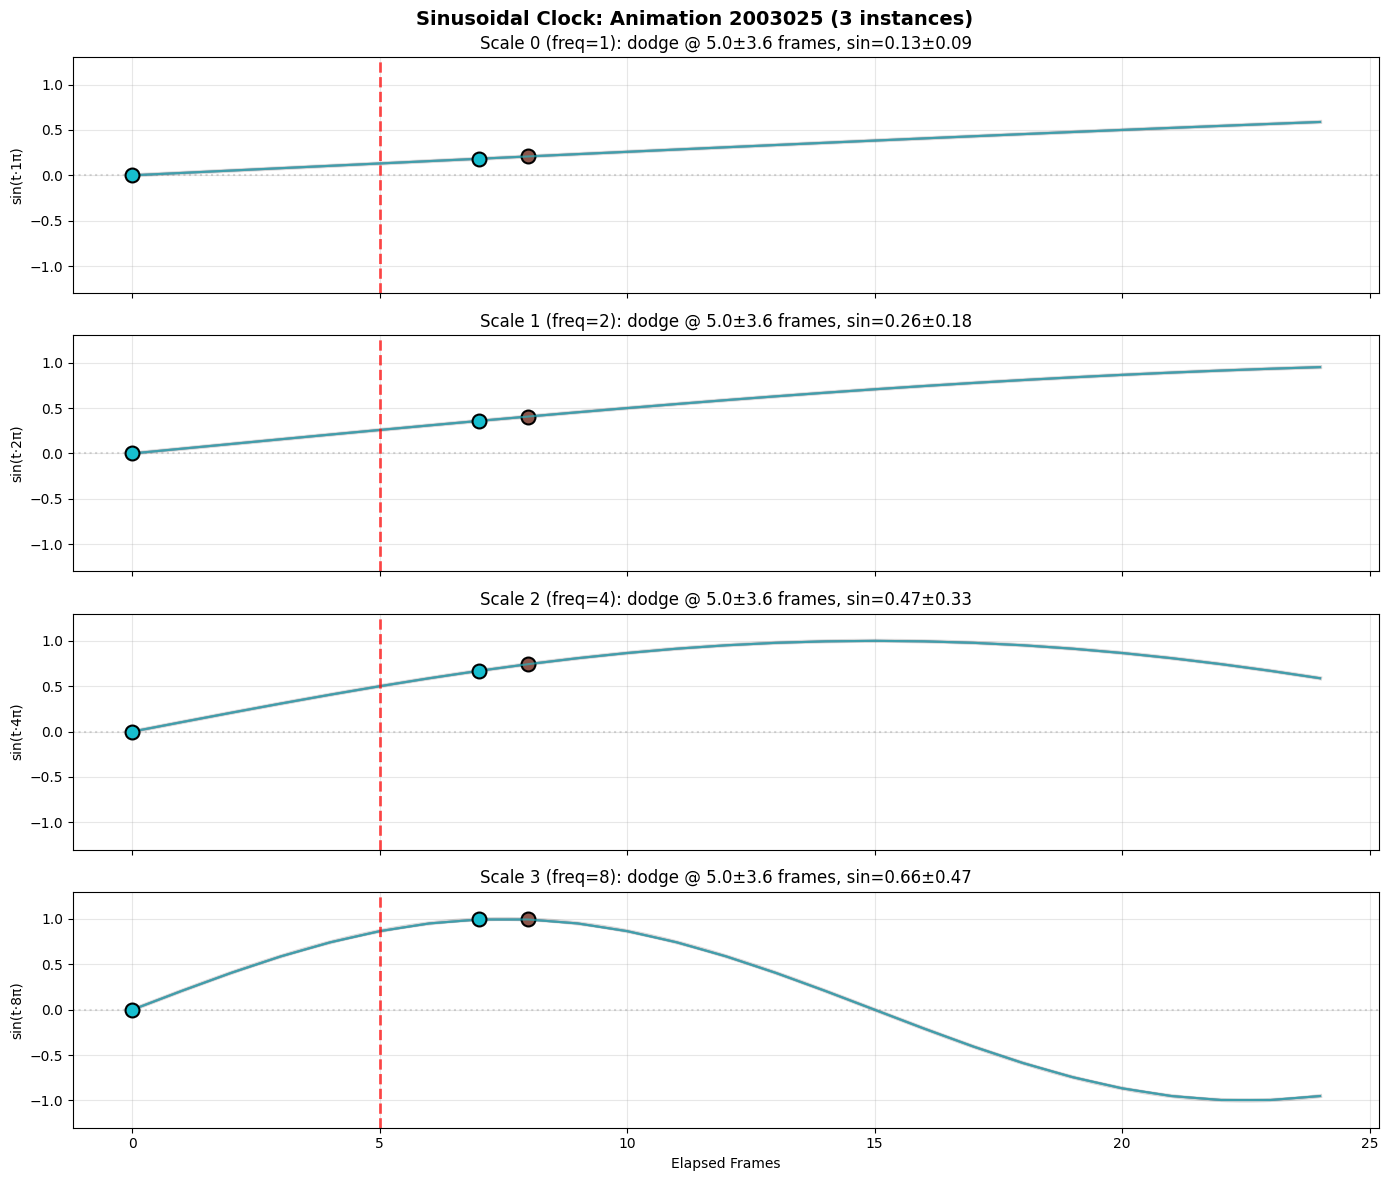


Dodge timing summary:
  Count: 3
  Mean: 5.0 frames
  Std: 3.6 frames
  CV: 0.71
  Range: [0, 8]

Found 2 instances of animation 2003024


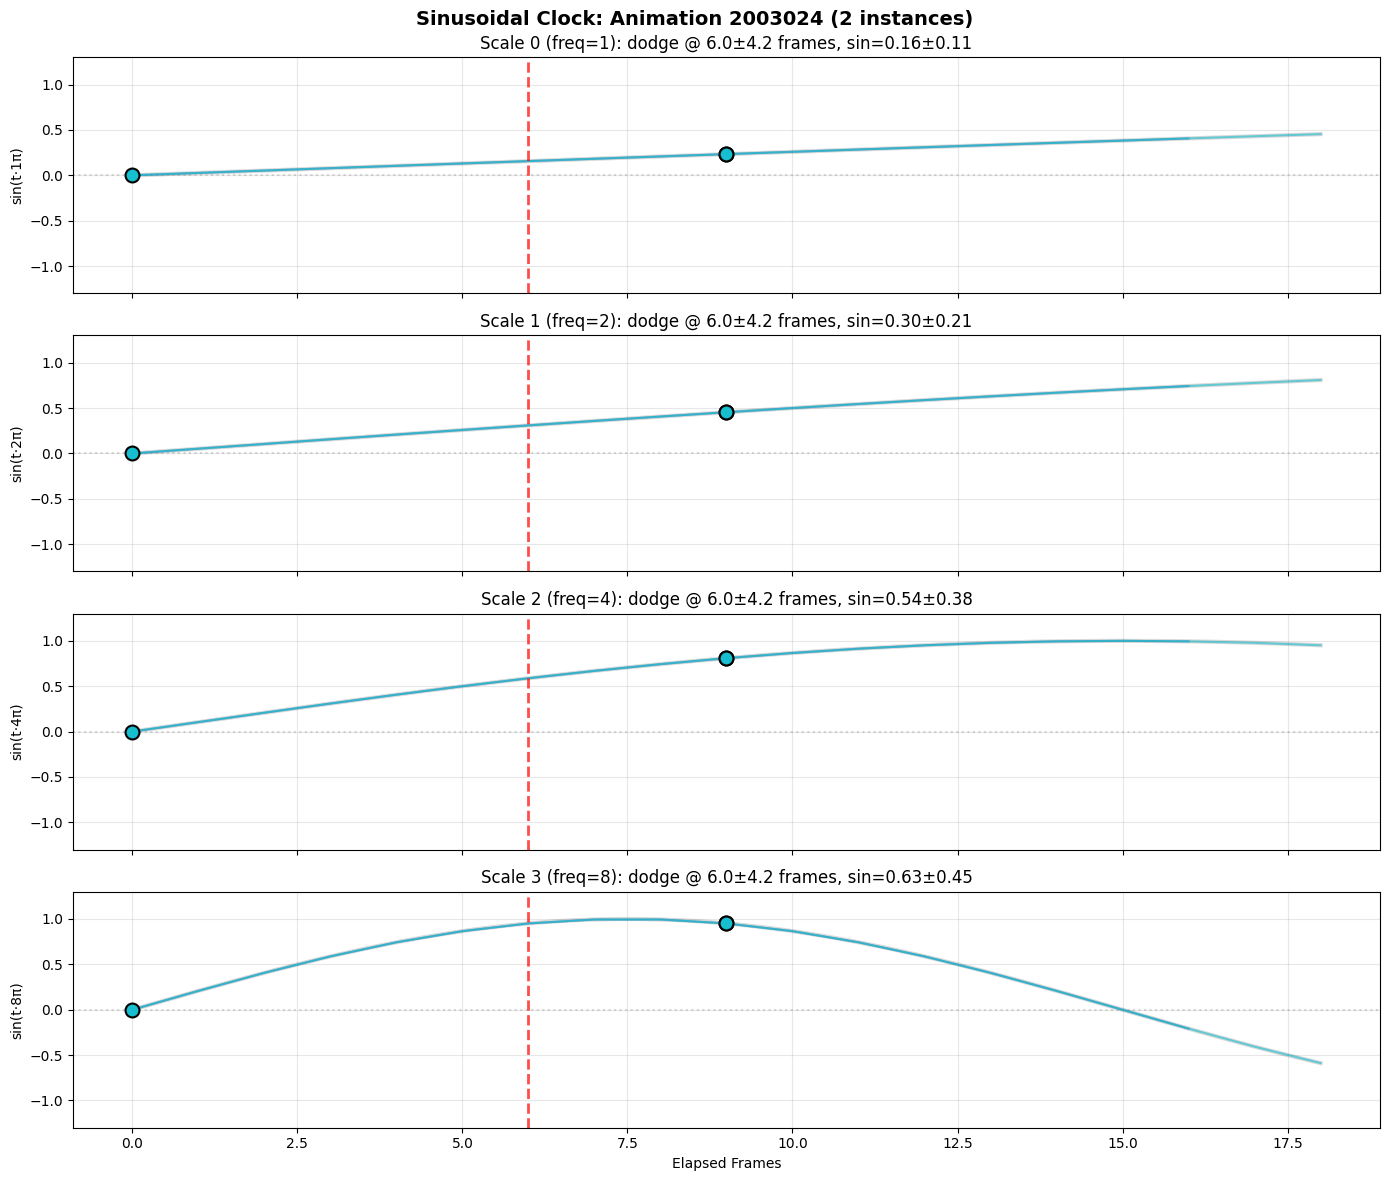


Dodge timing summary:
  Count: 3
  Mean: 6.0 frames
  Std: 4.2 frames
  CV: 0.71
  Range: [0, 9]


In [45]:
# Plot for all animations with multiple dodges
for anim_idx, onsets in sorted(dodge_by_anim.items(), key=lambda x: -len(x[1])):
    if len(onsets) >= 2:
        print("\n" + "="*60)
        plot_sinusoidal_timeline(recordings, anim_idx)

## Dodge Timing Histogram

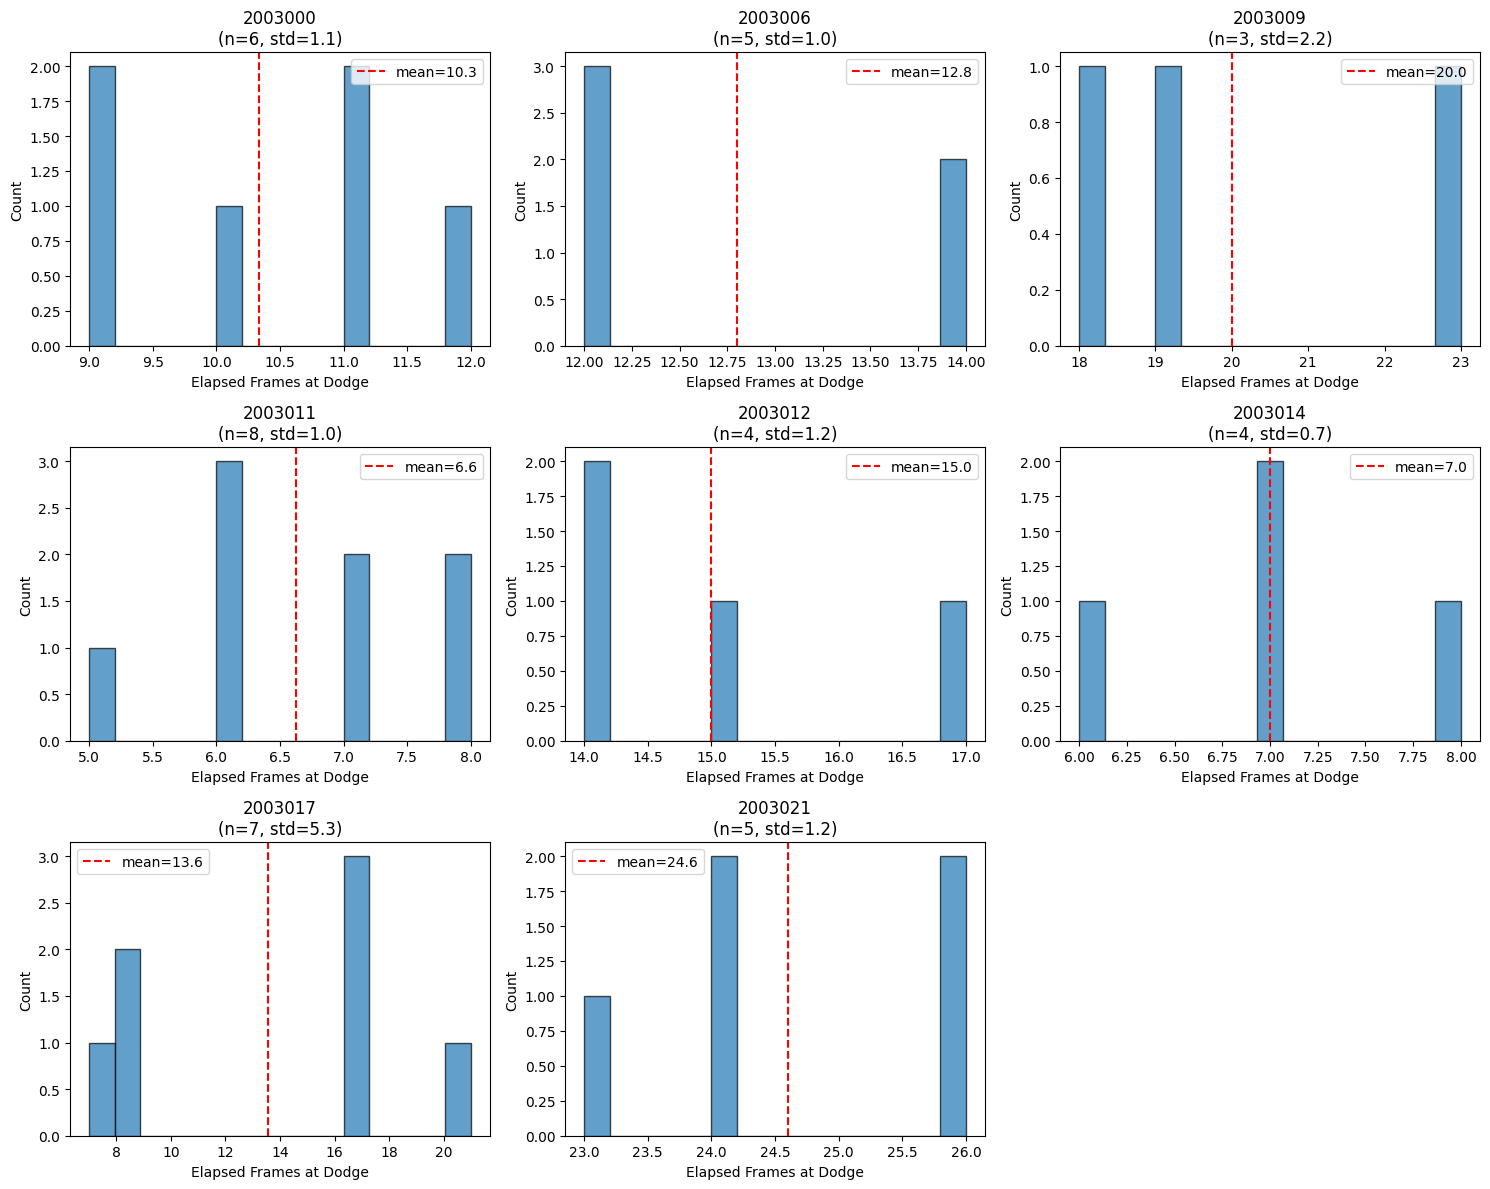

In [46]:
# Histogram of dodge elapsed times per animation
anims_with_dodges = {k: v for k, v in dodge_by_anim.items() if len(v) >= 3}

if anims_with_dodges:
    n_anims = len(anims_with_dodges)
    cols = min(3, n_anims)
    rows = (n_anims + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4*rows))
    axes = np.atleast_1d(axes).flatten()
    
    for idx, (anim_idx, onsets) in enumerate(sorted(anims_with_dodges.items())):
        ax = axes[idx]
        elapsed_vals = [o['boss_elapsed'] for o in onsets]
        anim_name = IDX_TO_ANIM.get(anim_idx, f"idx_{anim_idx}")
        
        ax.hist(elapsed_vals, bins=15, edgecolor='black', alpha=0.7)
        ax.axvline(np.mean(elapsed_vals), color='red', linestyle='--', 
                   label=f'mean={np.mean(elapsed_vals):.1f}')
        ax.set_xlabel('Elapsed Frames at Dodge')
        ax.set_ylabel('Count')
        ax.set_title(f'{anim_name}\n(n={len(onsets)}, std={np.std(elapsed_vals):.1f})')
        ax.legend()
    
    for idx in range(n_anims, len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.show()
else:
    print("Not enough dodge data for histograms")

## Raw Data Exploration

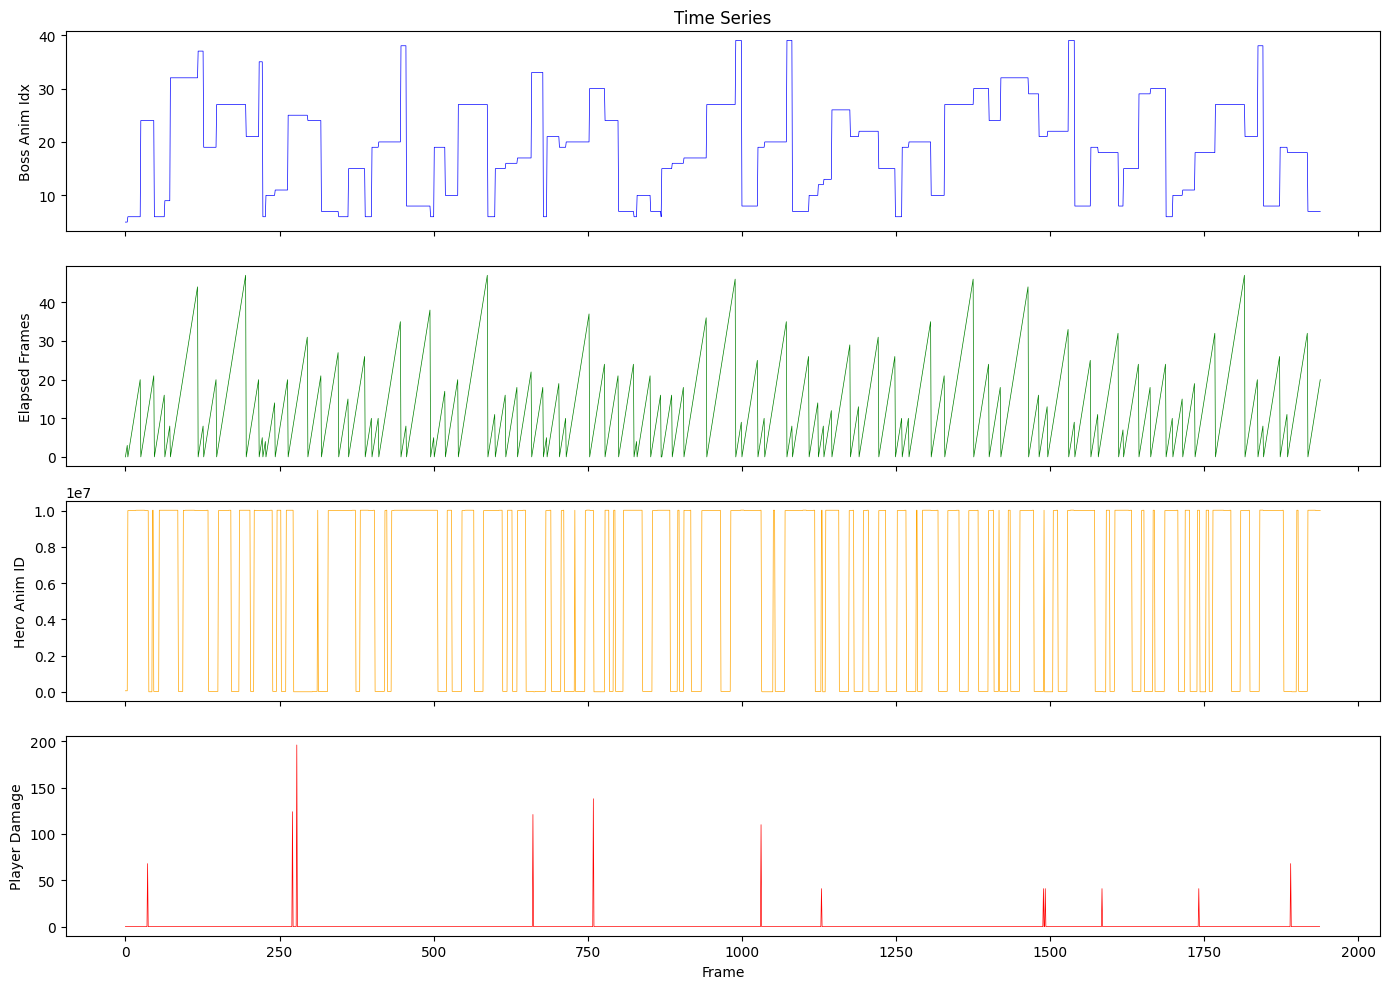

In [47]:
# Plot raw time series for a recording
if recordings:
    rec = recordings[0]
    
    fig, axes = plt.subplots(4, 1, figsize=(14, 10), sharex=True)
    
    # Boss animation
    axes[0].plot(rec['anim_idx'], 'b-', linewidth=0.5)
    axes[0].set_ylabel('Boss Anim Idx')
    axes[0].set_title('Time Series')
    
    # Elapsed frames
    axes[1].plot(rec['elapsed_frames'], 'g-', linewidth=0.5)
    axes[1].set_ylabel('Elapsed Frames')
    
    # Player animation (if available)
    if 'hero_anim_id' in rec:
        axes[2].plot(rec['hero_anim_id'], 'orange', linewidth=0.5)
        axes[2].set_ylabel('Hero Anim ID')
    
    # Player damage
    axes[3].plot(rec['player_damage'], 'r-', linewidth=0.5)
    axes[3].set_ylabel('Player Damage')
    axes[3].set_xlabel('Frame')
    
    plt.tight_layout()
    plt.show()